# **IMPORTS and DIRECTORIES**

In [ ]:
!pip3 install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 25.9 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import os
from os.path import exists, join, basename, splitext
import datetime
from datetime import datetime, timedelta
import math
from typing import Callable, Optional, List, Union, Dict, Tuple
import random
random.seed(1337)

import subprocess
import traceback

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer, LightningModule, Callback
from torch.nn.modules.dropout import _DropoutNd
from typing import Any

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d as Interp1D
from scipy.spatial.distance import euclidean

import yaml
from matplotlib.patches import FancyBboxPatch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_DIR = '/content/drive/MyDrive/Napoli_Project'
DATASET_DIR = PROJECT_DIR + '/dataset'
FILES_DIR = PROJECT_DIR + '/files'
EXPERIMENTS_DIR = PROJECT_DIR + '/experiments'

JSON_VIDEO_JOINTS_AMA_DIR = FILES_DIR+"/AMATEURS/json_video_joints"
FRAMES_AMA_DIR = FILES_DIR+"/AMATEURS/frames"
JSON_VIDEO_JOINTS_EXP_DIR = FILES_DIR+"/EXPERTS/json_video_joints"
FRAMES_EXP_DIR = FILES_DIR+"/EXPERTS/frames"


# **OPENPOSE INSTALLATION**

Install the pre-trained model called [*OpenPose*](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git), which lets us extract the body_joints from the videos (pose in COCO standard).

Note that: to use COCO standard, we modified the "openpose/CMakeLists.txt" file in order to build an instance of OpenPose based only on COCO model (by default the installation process downloads only BODY_25 model).

In [ ]:
# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 120872 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh" -O models.zip && rm -rf /tmp/cookies.txt

--2023-11-14 10:42:03--  https://docs.google.com/uc?export=download&confirm=t&id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh
Resolving docs.google.com (docs.google.com)... 74.125.139.101, 74.125.139.138, 74.125.139.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.139.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vhlveo16kl084g0id0obf1rc7tkqv2sc/1699958475000/01999283555521790548/*/1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh?e=download&uuid=e41485b6-5519-4118-be1d-cd9c2f909d8b [following]
--2023-11-14 10:42:04--  https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vhlveo16kl084g0id0obf1rc7tkqv2sc/1699958475000/01999283555521790548/*/1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh?e=download&uuid=e41485b6-5519-4118-be1d-cd9c2f909d8b
Resolving doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)... 74.125.139.132, 

In [ ]:
#@title
# Workaround for server connection problem ("file DOWNLOAD HASH mismatch"),see, e.g.,
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/1602#issuecomment-641653411
!apt-get install unzip

# !wget -O models.zip  --no-check-certificate -r 'https://drive.google.com/uc?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download'
!unzip -o models.zip -d openpose

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Archive:  models.zip
 extracting: openpose/models/pose/coco/pose_iter_440000.caffemodel  
 extracting: openpose/models/pose/coco/main.html  
 extracting: openpose/models/pose/mpi/pose_iter_160000.caffemodel  
 extracting: openpose/models/pose/body_25/pose_iter_584000.caffemodel  
 extracting: openpose/models/pose/body_25/training_results_source.txt  
 extracting: openpose/models/pose/body_25/training_log.txt  
   creating: openpose/models/pose/body_21a_video/
 extracting: openpose/models/pose/body_21a_video/pose_deploy.prototxt  
 extracting: openpose/models/pose/body_21a_video/pose_iter_264000.caffemodel  
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/body_25b/
 extracting: openpose/models/pose/1_25BSu

In [ ]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [ ]:
# build openpose
# CUDA
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. -DUSE_CUDNN=OFF && make -j`nproc`
#!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
# CPU
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF .. && cmake --build . --config Release && make -j`nproc`

!cd openpose && rm -rf build || true && mkdir build

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [ ]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "11.8") 
-- Building with CUDA.
-- CUDA detected: 11.8
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

# **CREATION OF THE DATASETS**

##**VIDEO PATHS DATAFRAMES**

Take the AMATEURS and EXPERTS folders, containing videos taken from the [*THETIS Dataset*](http://thetis.image.ece.ntua.gr/) (we chose to use only RGB videos, to see all the other folders click the link).

In [ ]:
#build the initial video dataset table, by extracting video paths from the AMATEURS folder

dir_dataset = os.listdir(DATASET_DIR+'/AMATEURS')

shots = []

for channel in dir_dataset:
  dir_specific_shot = os.listdir(DATASET_DIR + '/AMATEURS/' + channel)
  for video_file in dir_specific_shot:
    shots.append(((channel, str(DATASET_DIR + '/AMATEURS/' + channel) + video_file, str(video_file))))

amateurs_df = pd.DataFrame(data=shots,columns=['label','video_path','video_name'])
num_ama_rows, _ = amateurs_df.shape
print(num_ama_rows)
print(amateurs_df)
amateurs_df.to_csv(FILES_DIR + '/amateurs_df.csv', index=False)

1116
               label                                         video_path  \
0     backhand_slice  /content/drive/MyDrive/Napoli_Project/dataset/...   
1     backhand_slice  /content/drive/MyDrive/Napoli_Project/dataset/...   
2     backhand_slice  /content/drive/MyDrive/Napoli_Project/dataset/...   
3     backhand_slice  /content/drive/MyDrive/Napoli_Project/dataset/...   
4     backhand_slice  /content/drive/MyDrive/Napoli_Project/dataset/...   
...              ...                                                ...   
1111           smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
1112           smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
1113           smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
1114           smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
1115           smash  /content/drive/MyDrive/Napoli_Project/dataset/...   

             video_name  
0     p11_bslice_s3.avi  
1     p10_bslice_s3.avi  
2     p10_bslice

In [ ]:
#build the initial video dataset table, by extracting video paths from the EXPERTS folder

dir_dataset = os.listdir(DATASET_DIR + '/EXPERTS')

shots = []

for channel in dir_dataset:
  dir_specific_shot = os.listdir(DATASET_DIR + '/EXPERTS/' + channel)
  for video_file in dir_specific_shot:
    shots.append(((channel, str(DATASET_DIR + '/EXPERTS/' + channel) + video_file, str(video_file))))

experts_df = pd.DataFrame(data=shots,columns=['label','video_path','video_name'])
num_exp_rows, _ = experts_df.shape
print(num_exp_rows)
print(experts_df)
experts_df.to_csv(FILES_DIR + '/experts_df.csv', index=False)

864
            label                                         video_path  \
0    flat_service  /content/drive/MyDrive/Napoli_Project/dataset/...   
1    flat_service  /content/drive/MyDrive/Napoli_Project/dataset/...   
2    flat_service  /content/drive/MyDrive/Napoli_Project/dataset/...   
3    flat_service  /content/drive/MyDrive/Napoli_Project/dataset/...   
4    flat_service  /content/drive/MyDrive/Napoli_Project/dataset/...   
..            ...                                                ...   
859         smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
860         smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
861         smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
862         smash  /content/drive/MyDrive/Napoli_Project/dataset/...   
863         smash  /content/drive/MyDrive/Napoli_Project/dataset/...   

             video_name  
0    p34_serflat_s2.avi  
1    p35_serflat_s3.avi  
2    p36_serflat_s2.avi  
3    p33_serflat_s3.avi  
4

In [ ]:
print("Total number of videos after creating dataframes: ", num_ama_rows+num_exp_rows)

Total number of videos after creating dataframes:  1980


##**JSON VIDEO JOINTS**

In [ ]:
#method to extract body_joints from one video

def extract_features(label_name, complete_name, category):
  video_name = complete_name.split(".")[0]
  dir_frames_video = FILES_DIR + '/' + category + '/frames/' + video_name + '_tmp_frames/'
  dir_output_json = FILES_DIR + '/' + category + '/json_video_joints/' + video_name + '_output_json/'

  try:
    os.makedirs(dir_frames_video)
  except OSError as e1:
    print("Creation of the directory %s failed" % dir_frames_video)
    print("Error:", e1)
    print(traceback.format_exc())
  try:
    os.makedirs(dir_output_json)
  except OSError as e2:
    print("Creation of the directory %s failed" % dir_output_json)
    print("Error:", e2)
    print(traceback.format_exc())

  input_file = DATASET_DIR + '/' + category + '/' + label_name + '/' + complete_name
  output_file = dir_frames_video + '%09d.png'

  #divide videos in frames
  try:
    subprocess.run(['ffmpeg', '-i', input_file, output_file], check=True)
  except subprocess.CalledProcessError as e:
    print("ffmpeg command failed:", e)

  # detect poses
  !rm openpose.avi

  image_dir = dir_frames_video
  output_json = dir_output_json

  #takes frames folder and, for each frame, extracts body_joint features and put them in output_json
  command = f"cd openpose && ./build/examples/openpose/openpose.bin --model_pose COCO --image_dir {image_dir} --write_json {output_json} --display 0 --number_people_max 1 --write_video_fps 18 --write_video ../openpose.avi"


  process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()

In [ ]:
try:
  os.makedirs(FRAMES_AMA_DIR)
except OSError as e1:
  print("Creation of the directory %s failed" % FRAMES_AMA_DIR)
  print("Error:", e1)
  print(traceback.format_exc())

try:
  os.makedirs(JSON_VIDEO_JOINTS_AMA_DIR)
except OSError as e2:
  print("Creation of the directory %s failed" % JSON_VIDEO_JOINTS_AMA_DIR)
  print("Error:", e2)
  print(traceback.format_exc())

try:
  os.makedirs(FRAMES_EXP_DIR)
except OSError as e1:
  print("Creation of the directory %s failed" % FRAMES_EXP_DIR)
  print("Error:", e1)
  print(traceback.format_exc())

try:
  os.makedirs(JSON_VIDEO_JOINTS_EXP_DIR)
except OSError as e2:
  print("Creation of the directory %s failed" % JSON_VIDEO_JOINTS_EXP_DIR)
  print("Error:", e2)
  print(traceback.format_exc())


In [ ]:
#take from amateurs_df (a pd.DataFrame) the useful data to build the dataset, and put them in json_video_joints folder
amateurs_df = pd.read_csv(FILES_DIR+'/amateurs_df.csv')
for index, row in amateurs_df.iterrows():
  extract_features(row['label'], row['video_name'], 'AMATEURS')

In [ ]:
#take from experts_df (a pd.DataFrame) the useful data to build the dataset, and put them in json_video_joints folder
experts_df = pd.read_csv(FILES_DIR+'/experts_df.csv')
for index, row in experts_df.iterrows():
  extract_features(row['label'], row['video_name'], 'EXPERTS')

In [ ]:
amateurs_file_counter = len(os.listdir(JSON_VIDEO_JOINTS_AMA_DIR))
experts_file_counter = len(os.listdir(JSON_VIDEO_JOINTS_EXP_DIR))
print("Number of AMATEURS json files: ", amateurs_file_counter)
print("Number of EXPERTS json files: ", experts_file_counter)
print("Total json files: ", amateurs_file_counter+experts_file_counter)

##**DATASETS LISTS**

In [ ]:
#takes as input one json file, representing one frame, and converts it into an array of joint coordinates

def json_to_list(dir_json_files, file_json):

  try:
    my_json_file = open(os.path.join(dir_json_files,file_json),'r') #open the particular json file corresponding to the currently analized frame
    json_data = my_json_file.read()
    obj = json.loads(json_data) #convert json file to a python object
    array_joints = obj['people']# get("pose_keypoints_2d")

    if not array_joints:
      print("my list of people is empty")
      return []
    else:
      array_joints = obj['people'][0]["pose_keypoints_2d"]
      return array_joints
  except FileNotFoundError:
    print("my_json_file not found.")
  except:
    print("An error occurred while loading the my_json_file.")

In [ ]:
#create the dataset list, strarting from video_joints folder

def create_dataset_list(dataset_list, video_joints_dir, category):

  dataset_dir_list = os.listdir(video_joints_dir)

  for folder in dataset_dir_list: #for each video in json format
    dir_folder = video_joints_dir + "/" + folder
    dir_folder_list = os.listdir(dir_folder) #iterate for each frame in json format

    video = []
    name = str(folder)
    label_name = name.split('_')[1] #string that represents the type of stroke

    if label_name not in ['bvolley', 'bslice']: #since there aren't enough samples, we decided to exclude them
      for f_json in dir_folder_list: #for each frame in json format
        frame = json_to_list(dir_folder, f_json)
        video.append(frame)

      video.insert(0, label_name) #insert type of stroke at 2nd place in video list
      video.insert(0, category) #insert player category at 1st place in video list
      video.insert(0, name)

      dataset_list.append(video)


In [ ]:
#create and save the list corresponding to AMATEURS dataset in a ".pickle" file (binary file)
amateurs_dataset_list = []

create_dataset_list(amateurs_dataset_list, JSON_VIDEO_JOINTS_AMA_DIR, "AMATEUR")

amateurs_dataset_list_len = len(amateurs_dataset_list)
print("This is the number of AMATEURS videos after the creation of the list: ", amateurs_dataset_list_len)

with open(FILES_DIR+"/amateurs_dataset_list.pickle", "wb") as file:
    pickle.dump(amateurs_dataset_list, file)

In [ ]:
#create and save the list corresponding to EXPERTS dataset in a ".pickle" file (binary file)
experts_dataset_list = []

create_dataset_list(experts_dataset_list, JSON_VIDEO_JOINTS_EXP_DIR, "EXPERT")

experts_dataset_list_len = len(experts_dataset_list)
print("This is the number of EXPERTS videos after the creation of the list: ", experts_dataset_list_len)

with open(FILES_DIR+"/experts_dataset_list.pickle", "wb") as file:
    pickle.dump(experts_dataset_list, file)

#**PREPROCESSING**

## **DATASET LIST**

In [ ]:
with open(FILES_DIR+"/amateurs_dataset_list.pickle", "rb") as file:
    amateurs_dataset_list = pickle.load(file)
print(amateurs_dataset_list[0])

['p10_backhand_s1_output_json', 'AMATEUR', 'backhand', [341.184, 108.824, 0.920842, 338.519, 138.846, 0.914479, 307.241, 138.868, 0.879224, 295.457, 179.326, 0.765034, 311.122, 204.098, 0.646619, 368.559, 138.824, 0.85369, 380.233, 187.166, 0.852605, 341.198, 209.305, 0.76891, 317.614, 234.139, 0.778965, 298.028, 296.794, 0.889565, 284.991, 352.929, 0.840706, 358.1, 234.139, 0.767077, 369.836, 295.457, 0.84012, 371.196, 350.287, 0.899736, 337.233, 102.3, 0.875148, 348.937, 101.021, 0.93641, 326.778, 108.778, 0.907617, 355.516, 106.221, 0.767903], [339.912, 108.779, 0.927974, 338.516, 138.855, 0.912918, 307.248, 138.865, 0.872347, 294.166, 178.003, 0.754867, 309.83, 202.853, 0.663595, 368.549, 138.839, 0.855075, 379.019, 188.467, 0.847857, 339.9, 208.003, 0.794511, 317.617, 234.133, 0.779553, 298.047, 296.756, 0.889631, 283.741, 352.929, 0.830196, 358.088, 234.143, 0.754721, 369.814, 295.438, 0.824514, 371.208, 350.294, 0.891445, 335.947, 101.022, 0.870323, 347.693, 100.994, 0.925884, 3

In [ ]:
with open(FILES_DIR+"/experts_dataset_list.pickle", "rb") as file:
    experts_dataset_list = pickle.load(file)
print(experts_dataset_list[0])

['p32_backhand2h_s1_output_json', 'EXPERT', 'backhand2h', [337.241, 141.479, 0.929107, 338.542, 178.016, 0.88201, 307.164, 176.716, 0.818196, 299.417, 223.734, 0.89937, 329.355, 235.384, 0.881424, 369.907, 181.861, 0.860846, 369.906, 226.309, 0.850198, 355.503, 264.137, 0.74039, 317.667, 265.43, 0.821206, 307.168, 328.131, 0.835631, 301.989, 392.092, 0.819896, 356.835, 265.491, 0.781833, 372.453, 328.112, 0.881681, 380.33, 392.072, 0.894333, 329.358, 137.528, 0.929738, 341.15, 134.959, 0.868537, 319.01, 141.453, 0.868099, 351.578, 140.114, 0.950173], [338.477, 141.46, 0.954221, 338.556, 179.298, 0.894744, 307.175, 178, 0.842295, 299.411, 223.742, 0.887427, 329.359, 235.44, 0.862569, 371.121, 181.855, 0.867931, 369.92, 226.315, 0.86368, 352.915, 262.845, 0.766356, 317.694, 266.723, 0.824442, 307.168, 329.381, 0.832603, 302.007, 392.074, 0.822667, 358.102, 266.764, 0.787537, 371.241, 328.156, 0.876522, 380.307, 392.092, 0.893817, 329.379, 137.518, 0.931321, 341.182, 134.919, 0.862533, 31

In [ ]:
amateurs_dataset_list_len = len(amateurs_dataset_list)
experts_dataset_list_len = len(experts_dataset_list)
print("Number of total videos after the creation of the lists: ", amateurs_dataset_list_len+experts_dataset_list_len)

Number of total videos after the creation of the lists:  1620


In [ ]:
#combine the datasets lists

dataset_list = amateurs_dataset_list + experts_dataset_list
print(len(dataset_list))

1620


In [ ]:
with open(FILES_DIR+"/dataset_list.pickle", "wb") as file:
    pickle.dump(dataset_list, file)

In [ ]:
dict_categories = {"AMATEUR" : 0, "EXPERT" : 1}

dict_strokes = {
    'backhand': 0,
    'bslice': 1, #no samples, remove it
    'bvolley': 2, #too few samples, remove it
    'backhand2h': 3, # missing 30 videos, but still keep it
    'serflat': 4,
    'foreflat': 5,
    'foreopen': 6,
    'fslice': 7,
    'fvolley': 8,
    'serkick': 9,
    'serslice': 10,
    'smash': 11
}

In [ ]:
# create dataset list with player category and type of stroke executed
with open(FILES_DIR+"/dataset_list.pickle", "rb") as file:
    dataset_list = pickle.load(file)

cat_and_stroke_list = []

for video in dataset_list:
  cat_and_stroke_list.append([dict_categories[video[1]], dict_strokes[video[2]]])

In [ ]:
print(len(cat_and_stroke_list))
print(cat_and_stroke_list[0])

1620
[0, 0]


In [ ]:
with open(FILES_DIR+"/cat_and_stroke_list.pickle", "wb") as file:
    pickle.dump(cat_and_stroke_list, file)

In [ ]:
# list of all videos with only frames (each joint without confidence score);
# replace zero coordinates, due to measurement errors in the algorithm itself
# or external factors (occlusions, chromatic aberrations, etc.) with neighbor values

videos_list = []

for i in range(0,len(dataset_list)):
  frames_list = []
  for j in range(3,len(dataset_list[i])):
    single_frame = []
    if str(type(dataset_list[i][j])) != "<class 'NoneType'>":
      for k in range(0,len(dataset_list[i][j])):
        if (k+1)%3 != 0: # if it's not a confidence score (which is in multiple-of-3 positions)
          if dataset_list[i][j][k] != 0.0:
            single_frame.append(dataset_list[i][j][k])
          else:
            if j == 3: # first frame
              following_values = [dataset_list[i][f][k] for f in range (j+1, len(dataset_list[i]))]
              for elem in following_values:
                if elem != 0:
                  first_non_zero_value = elem
                  break
              single_frame.append(first_non_zero_value) # append same value as the following frame
            elif j == len(dataset_list[i]) - 1: # last frame
              # since frames_list contains new frames without confidence score, the new length is 36 (and not 48 anymore!),
              # so we have to adapt the k-index
              new_k = int((k/3)*2 + k%3)
              single_frame.append(frames_list[-1][new_k]) # append same value as the previous frame
            else: # in-between frame
              # since frames_list contains new frames without confidence score, the new length is 36 (and not 48 anymore!),
              # so we have to adapt the k-index
              new_k = int((k/3)*2 + k%3)
              previous = frames_list[-1][new_k]

              following_values = [dataset_list[i][f][k] for f in range (j+1, len(dataset_list[i]))]
              for elem in following_values:
                if elem != 0:
                  next = elem
                  break

              mean_value = (previous + next)/2

              single_frame.append(mean_value)

      frames_list.append(single_frame)

  videos_list.append(frames_list)

In [ ]:
with open(FILES_DIR+"/videos_list.pickle", "wb") as file:
    pickle.dump(videos_list, file)

## **TIME INTERVAL ADAPTATION**

In [ ]:
with open(FILES_DIR+"/videos_list.pickle", "rb") as file:
    videos_list = pickle.load(file)

In [ ]:
def time_normalization(video, target_len):
    # Calculate original and target time points
    original_len = len(video)
    original_times = np.linspace(0, 1, original_len)
    target_times = np.linspace(0, 1, target_len)

    # Interpolate each feature
    normalized_video = []
    for i in range(len(video[0])):
        # Extract the single feature from all frames
        single_joint_coords = [frame[i] for frame in video]

        interp_func = Interp1D(original_times, single_joint_coords, kind='linear')

        # Compute interpolated values at new time points
        interp_single_joint_coords = interp_func(target_times)

        normalized_video.append(interp_single_joint_coords)

    # Transpose the list to get the final sequence
    return np.array(normalized_video).T


In [ ]:
video_lengths = [len(video) for video in videos_list]
max_length = max(video_lengths)
print(max_length)

In [ ]:
time_normalized_data = [time_normalization(video, max_length) for video in videos_list]
time_normalized_data = np.array(time_normalized_data)

In [ ]:
print(time_normalized_data.shape)

In [ ]:
with open(FILES_DIR+"/time_normalized_data.pickle", "wb") as file:
    pickle.dump(time_normalized_data, file)

## **NORMALIZATION**

In [ ]:
with open(FILES_DIR+"/time_normalized_data.pickle", "rb") as file:
    time_normalized_data = pickle.load(file)

In [ ]:
def plot_data(data):
    """
    Plots the first frame of each video to visualize the normalization of human figures.

    Parameters:
    data (list): List of joint data for multiple videos.
    """
    plt.figure(figsize=(12, 8))

    for i, video in enumerate(data):
        if i >= 6:  # Plotting the first videos for clarity
            break

        joints = video[0]  # Assuming each video has at least one frame
        joints = torch.tensor(joints)  # Convert to PyTorch tensor if not already

        joints = joints.reshape(18, 2)

        x = joints[:, 0]
        y = joints[:, 1]

        plt.subplot(2, 3, i + 1)
        plt.scatter(x, y)
        plt.plot(x, y)
        plt.title(f"Video {i + 1}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.gca().invert_yaxis()  # Inverting y-axis to have bodies in the right verse

    plt.tight_layout()
    plt.show()

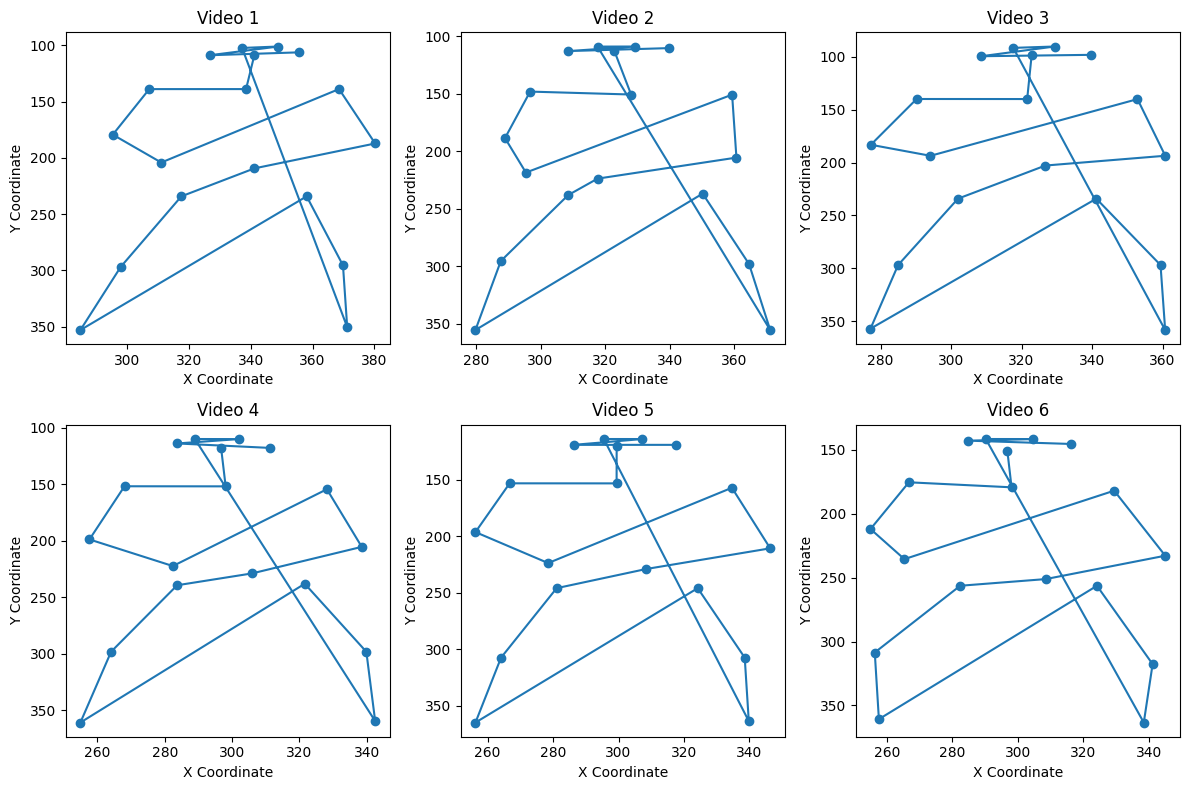

In [ ]:
plot_data(time_normalized_data)

In [ ]:
# Find min and max values for both x and y coordinates, among all videos

def find_min_max(data):

  total_x_min = float('inf')
  total_y_min = float('inf')
  total_x_max = float('-inf')
  total_y_max = float('-inf')

  for video in data:
    for frame in video:

      x_coords = [frame[i] for i in range(0, len(frame), 2)]
      y_coords = [frame[i] for i in range(1, len(frame), 2)]

      x_min = min(x_coords)
      x_max = max(x_coords)
      y_min = min(y_coords)
      y_max = max(y_coords)

      if x_min < total_x_min:
        total_x_min = x_min
      if x_max > total_x_max:
        total_x_max = x_max
      if y_min < total_y_min:
        total_y_min = y_min
      if y_max > total_y_max:
        total_y_max = y_max

  return total_x_min, total_y_min, total_x_max, total_y_max


In [ ]:
x_min, y_min, x_max, y_max = find_min_max(time_normalized_data)

print(x_min, y_min, x_max, y_max)

3.7282183783783784 3.086764054054054 643.996445945946 476.95432432432426


In [ ]:
# Define a custom normalization function that normalizes x and y values in a space between 0 and 1

def min_max_normalization(data, x_min, y_min, x_max, y_max):

  x_interval = x_max - x_min
  y_interval = y_max - y_min

  norm_data = []

  for video in data:
    norm_video = []

    for i, frame in enumerate(video):
      norm_frame = np.copy(frame)
      steps = int(len(frame)/2)

      for k in range(steps):
        norm_frame[2*k] = (frame[2*k] - x_min)/x_interval
        norm_frame[(2*k)+1] = (frame[(2*k)+1] - y_min)/y_interval

      norm_video.append(norm_frame)

    norm_data.append(np.array(norm_video))

  norm_data = np.array(norm_data)

  return norm_data


In [ ]:
def plot_normalized_data(data, norm_data):

    plt.figure(figsize=(12, 12))

    for i, video in enumerate(data):
        if i >= 12:  # Plotting the first 12 videos for clarity
            break

        joints = video[0]  # Assuming each video has at least one frame
        joints = torch.tensor(joints)  # Convert to PyTorch tensor if not already

        joints = joints.reshape(18, 2)

        x = joints[:, 0]
        y = joints[:, 1]

        norm_joints = norm_data[i][0]  # Assuming each video has at least one frame
        norm_joints = torch.tensor(norm_joints)  # Convert to PyTorch tensor if not already

        norm_joints = norm_joints.reshape(18, 2)

        norm_x = norm_joints[:, 0]
        norm_y = norm_joints[:, 1]

        plt.subplot(4, 3, i + 1)
        plt.scatter(x, y)
        plt.plot(x, y, label='data')
        plt.scatter(norm_x, norm_y)
        plt.plot(norm_x, norm_y, label='normalized data')
        plt.title(f"Video {i + 1}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.gca().invert_yaxis()
        plt.legend(loc='upper right')


    plt.tight_layout()
    plt.show()

In [ ]:
min_max_data = min_max_normalization(time_normalized_data, x_min, y_min, x_max, y_max)
print(min_max_data.shape)

In [ ]:
plot_normalized_data(time_normalized_data, min_max_data)

In [ ]:
with open(FILES_DIR+"/min_max_data.pickle", "wb") as file:
    pickle.dump(min_max_data, file)

## **SCALING**

In [ ]:
with open(FILES_DIR+"/min_max_data.pickle", "rb") as file:
    min_max_data = pickle.load(file)

In [ ]:
total_shoulder_distances = []
total_hip_distances = []

for video in min_max_data:
  shoulders = np.array([np.concatenate((frame[4:6],frame[10:12])) for frame in video])
  shoulder_distances = np.linalg.norm(shoulders[:, 2:4] - shoulders[:, 0:2], axis=1)
  total_shoulder_distances.append(shoulder_distances)

  hips = np.array([np.concatenate((frame[2:4],frame[15:17])) for frame in video])
  hip_distances = np.linalg.norm(hips[:, 2:4] - hips[:, 0:2], axis=1)
  total_hip_distances.append(hip_distances)

total_shoulder_distances = np.array(total_shoulder_distances)
total_hip_distances = np.array(total_hip_distances)

In [ ]:
# in case of distances = 0 (superposed shoulders), problem in the computation of scaling factor (division by zero!)
# substitution with mean value between the two boundary distances

total_shoulder_distances_copy = np.copy(total_shoulder_distances)

for i in range(len(total_shoulder_distances_copy)):
  if 0 in total_shoulder_distances_copy[i]:
    indices = np.where(total_shoulder_distances_copy[i] == 0)[0]
    for index in indices:
      if index == 0: # if it's in the first frame
        total_shoulder_distances[i][index] = total_shoulder_distances[i][index+1]
      elif index == len(total_shoulder_distances[i])-1: # if it's in the last frame
        total_shoulder_distances[i][index] = total_shoulder_distances[i][index-1]
      else:
        total_shoulder_distances[i][index] = (total_shoulder_distances[i][index-1]+total_shoulder_distances[i][index+1])/2

# further check
for elem in total_shoulder_distances:
  if 0 in elem:
    print(elem)

In [ ]:
# to normalize x-cordinates, compute mean distance between left and right shoulders

mean_shoulder_distances = []

for distances in total_shoulder_distances:
  mean_shoulder_distance = np.mean(distances)
  mean_shoulder_distances.append(mean_shoulder_distance)

mean_shoulder_distances = np.array(mean_shoulder_distances)
mean_total_shoulder_distance = np.mean(mean_shoulder_distances)

In [ ]:
# to normalize y-coordinates, compute mean distance between neck and right hip

mean_hip_distances = []

for distances in total_hip_distances:
  mean_hip_distance = np.mean(distances)
  mean_hip_distances.append(mean_hip_distance)

mean_hip_distances = np.array(mean_hip_distances)
mean_total_hip_distance = np.mean(mean_hip_distances)

In [ ]:
x_ref = mean_total_shoulder_distance
y_ref = mean_total_hip_distance

print(x_ref, y_ref)

0.08437897695402624 0.1683635200940172


In [ ]:
# compute scaling factors and multiply them by the coordinates to obtain the new normalized data

scaled_data = []

for i, video in enumerate(min_max_data):

  scaled_video = []

  for j, frame in enumerate(video):
    scaled_frame = np.copy(frame)
    steps = int(len(frame)/2)

    scale_x = x_ref/total_shoulder_distances[i][j]
    scale_y = y_ref/total_hip_distances[i][j]

    for k in range(steps):
     scaled_frame[2*k] = frame[2*k]*scale_x
     scaled_frame[(2*k)+1] = frame[(2*k)+1]*scale_y

    scaled_video.append(scaled_frame)

  scaled_data.append(np.array(scaled_video))

scaled_data = np.array(scaled_data)

In [ ]:
def plot_scaled_data(data, scaled_data):

    plt.figure(figsize=(12, 12))

    for i, video in enumerate(data):
        if i >= 12:  # Plotting the first videos for clarity
            break

        joints = video[10]  # Assuming each video has at least one frame
        joints = torch.tensor(joints)  # Convert to PyTorch tensor if not already

        joints = joints.reshape(18, 2)

        x = joints[:, 0]
        y = joints[:, 1]

        scaled_joints = scaled_data[i][10]  # Assuming each video has at least one frame
        scaled_joints = torch.tensor(scaled_joints)  # Convert to PyTorch tensor if not already

        scaled_joints = scaled_joints.reshape(18, 2)

        scaled_x = scaled_joints[:, 0]
        scaled_y = scaled_joints[:, 1]

        plt.subplot(4, 3, i + 1)
        plt.scatter(x, y)
        plt.plot(x, y, label='normal')
        plt.scatter(scaled_x, scaled_y)
        plt.plot(scaled_x, scaled_y, label='scaled')
        plt.title(f"Video {i + 1}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.gca().invert_yaxis()
        plt.legend(loc='upper right')


    plt.tight_layout()
    plt.show()

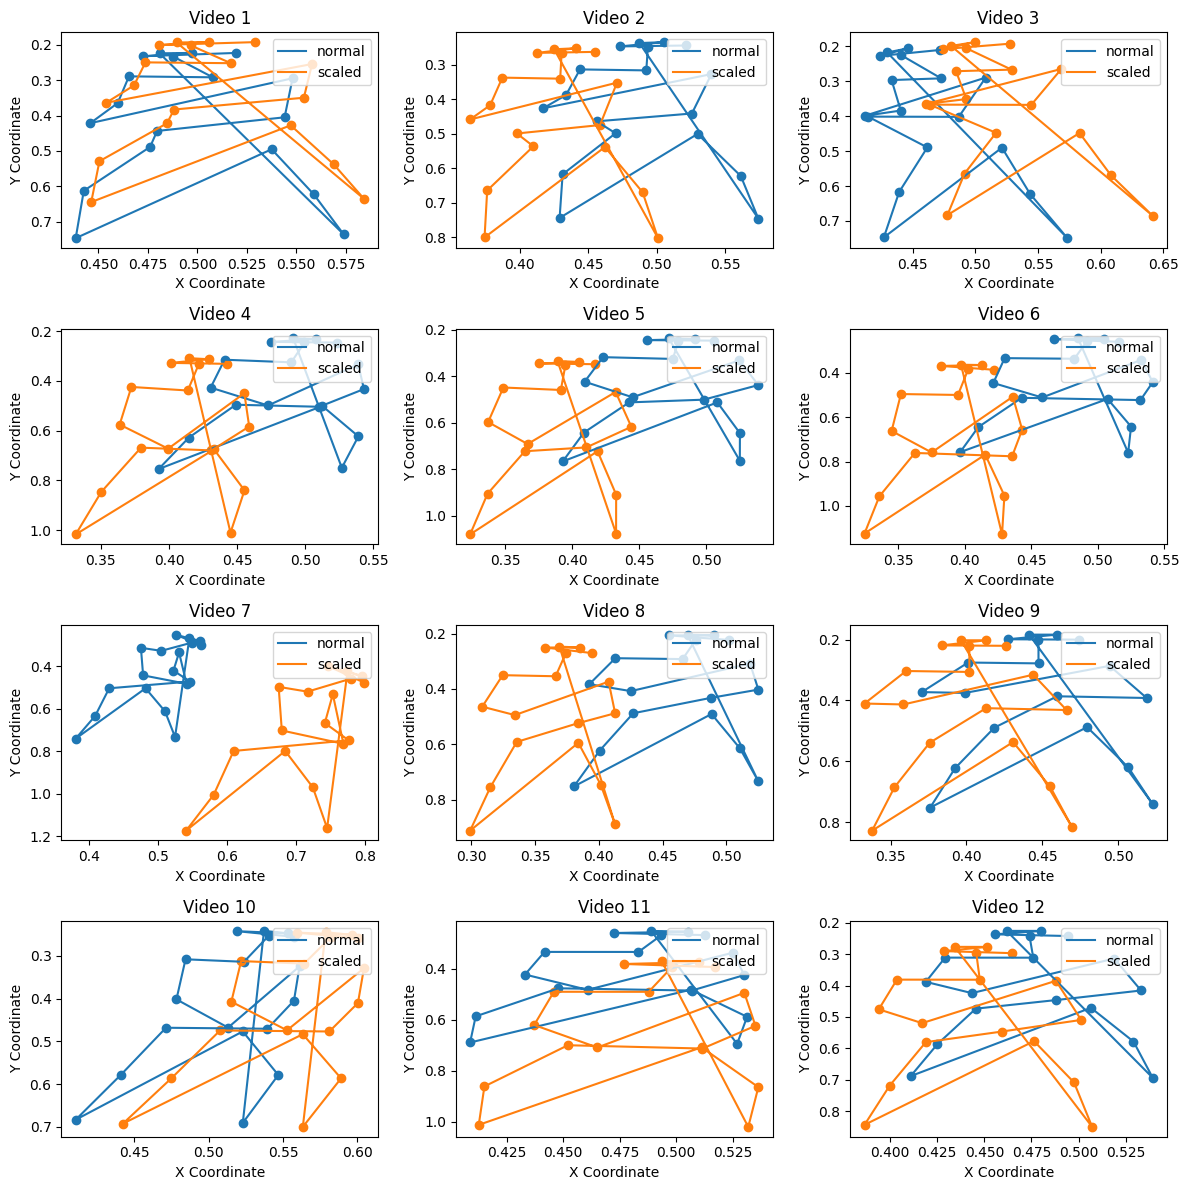

In [ ]:
plot_scaled_data(min_max_data, scaled_data)

In [ ]:
with open(FILES_DIR+"/scaled_data.pickle", "wb") as file:
    pickle.dump(scaled_data, file)

##**PCA**

In [ ]:
with open(FILES_DIR+"/scaled_data.pickle", "rb") as file:
    scaled_data = pickle.load(file)

In [ ]:
def euclidean_distance(p1,p2):
  return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [ ]:
def get_euclidean_distances(video):

  euclidean_video = []

  for i in range(0,len(video)):
    if i == 0:
      euclidean_frame = [0] * 18
    else:
      previous_frame = video[i-1]
      current_frame = video[i]
      euclidean_frame = [euclidean_distance(previous_frame[j],current_frame[j]) for j in range(18)]
    euclidean_video.append(np.array(euclidean_frame))

  euclidean_video = np.array(euclidean_video)

  return euclidean_video


In [ ]:
scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 18, 2)

In [ ]:
euclidean_data = []

for video in scaled_data:
  euclidean_video = get_euclidean_distances(video)
  euclidean_data.append(euclidean_video)

euclidean_data = np.array(euclidean_data)

print(euclidean_data.shape)

In [ ]:
def find_num_comps(euclidean_data):

  pca = PCA()

  i = 0

  num_comps_to_keep = 0 # number of components such that all videos have at least 95% of variance

  for video in euclidean_data:
    pca_video = pca.fit_transform(video)

    # Obtain percentages of explained variance for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find the number of components s.t. for each video variance >= 95% is preserved
    variance_sum = 0.0
    for i, variance_ratio in enumerate(explained_variance_ratio):
      variance_sum += variance_ratio
      if variance_sum >= 0.95:
        current_num_comps = i+1
        if current_num_comps > num_comps_to_keep:
          num_comps_to_keep = current_num_comps
        break

  return num_comps_to_keep

In [ ]:
num_comps = find_num_comps(euclidean_data)

pca = PCA(n_components = num_comps)

pca_data = []

for video in euclidean_data:
  pca_video = pca.fit_transform(video)
  pca_data.append(pca_video)

pca_data = np.array(pca_data)

print(pca_data.shape)

In [ ]:
with open(FILES_DIR+"/pca_data.pickle", "wb") as file:
    pickle.dump(pca_data, file)

#**PERFORMANCE METRICS**

In [ ]:
with open(FILES_DIR+"/amateurs_dataset_list.pickle", "rb") as file:
    amateurs_dataset_list = pickle.load(file)

In [ ]:
with open(FILES_DIR+"/experts_dataset_list.pickle", "rb") as file:
    experts_dataset_list = pickle.load(file)

In [ ]:
dict_strokes = {
    'backhand': 0,
    'bslice': 1, #no samples, remove it
    'bvolley': 2, #too few samples, remove it
    'backhand2h': 3, # missing 30 videos, but still keep it
    'serflat': 4,
    'foreflat': 5,
    'foreopen': 6,
    'fslice': 7,
    'fvolley': 8,
    'serkick': 9,
    'serslice': 10,
    'smash': 11
}

In [ ]:
with open(FILES_DIR+"/scaled_data.pickle", "rb") as file:
    scaled_data = pickle.load(file)

In [ ]:
#Since scaled_data is a concatenation of AMATEURS and EXPERTS videos, we separate by taking the first 900 videos as AMATEURS

ama_scaled_data = scaled_data[:900]
exp_scaled_data = scaled_data[900:]

In [ ]:
#Obtain a dictionary with key = <tennis_stroke> and value = numpy array of videos related to <tennis_stroke>
def create_dict_stroke_array(data, dataset_list):
  dict_stroke_array = {}

  for i in range(0,len(data)):
    if dataset_list[i][2] in dict_strokes: #first check if the stroke is in the existing strokes in the dataset
      stroke_id = dict_strokes[dataset_list[i][2]] #take the label related to the stroke
      if stroke_id in dict_stroke_array:
        #if the stroke is already in the dictionary, then concatenate the video to the list of other videos already added
        dict_stroke_array[stroke_id] = np.concatenate((dict_stroke_array[stroke_id],[data[i]]))
      else:
        #initialize the list of videos for the new stroke found
        dict_stroke_array[stroke_id] = np.array([data[i]])

  dict_stroke_array = dict(sorted(dict_stroke_array.items()))
  for key in dict_stroke_array:
    print(key,dict_stroke_array[key].shape)

  return dict_stroke_array

In [ ]:
ama_dict_stroke_array = create_dict_stroke_array(ama_scaled_data, amateurs_dataset_list)

In [ ]:
exp_dict_stroke_array = create_dict_stroke_array(exp_scaled_data, experts_dataset_list)

In [ ]:
# compute AMATEURS distances from the set of experts executing the same strokes, using Mahalanobis distance

ama_mh_distances = []

for key in ama_dict_stroke_array:

  for i in range(len(ama_dict_stroke_array[key])):

    mahalanobis_distance = 0
    video = ama_dict_stroke_array[key][i]
    num_frames = len(video)

    for j in range(0,num_frames):
      # list of frames with same index j from experts list related to key
      frames_list = [exp_dict_stroke_array[key][k][j] for k in range(len(exp_dict_stroke_array[key]))]
      mean_reference = np.mean(frames_list, axis=0)
      cov_matrix_reference = np.cov(frames_list, rowvar=False)
      inv_cov_matrix_reference = np.linalg.inv(cov_matrix_reference)

      diff = video[j] - mean_reference
      mahalanobis_distance += np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix_reference), diff))

    mahalanobis_distance = mahalanobis_distance / num_frames
    ama_mh_distances.append(mahalanobis_distance)

for elem in ama_mh_distances:
  print(elem)

10.143101377596816
12.2571949307498
16.383198604334577
12.564860826685477
12.996572689756238
15.036650927746434
10.632045733406375
11.23925258239625
9.175471860673525
15.957352824029279
29.045731584466974
85.05158206941209
10.392446746343554
9.775539140759584
15.362179491519182
11.799226394115138
11.173914629112032
10.098893358909233
12.336526780716758
11.872284477457727
11.660430279953186
10.660276499253198
11.657184542273034
12.994853307199527
12.52875292419072
13.164166729350578
14.392092186760623
13.882249182624363
15.095821485524917
16.57525603981151
6.965083919665261
23.191600611548242
16.58955540591853
27.311457988109748
47.29125208578115
24.62750157509405
8.109788598898708
10.799270068330296
10.12200385729825
15.847276075936252
15.421003867711418
17.085804905041563
22.191501386986776
14.748768279224386
16.618152118586906
28.606832763266503
27.657886360566895
90.11777530981293
11.521179623391001
10.732379757876652
12.178080858320168
15.4792019656698
19.990928842397643
21.3927175

In [ ]:
# compute EXPERTS distances from the set of experts executing the same strokes, using Mahalanobis distance

exp_mh_distances = []

for key in exp_dict_stroke_array:

  for i in range(len(exp_dict_stroke_array[key])):

    idx = i + 900 # index in the mask list (which includes all videos); experts videos start from the 900th position
    mahalanobis_distance = 0
    video = exp_dict_stroke_array[key][i]
    num_frames = len(video)

    for j in range(0,num_frames):

      # list of frames with same index j from experts list related to key
      frames_list = [exp_dict_stroke_array[key][k][j] for k in range(len(exp_dict_stroke_array[key]))]
      mean_reference = np.mean(frames_list, axis=0)
      cov_matrix_reference = np.cov(frames_list, rowvar=False)
      inv_cov_matrix_reference = np.linalg.inv(cov_matrix_reference)

      diff = video[j] - mean_reference
      mahalanobis_distance += np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix_reference), diff))

    mahalanobis_distance = mahalanobis_distance / num_frames
    exp_mh_distances.append(mahalanobis_distance)

for elem in exp_mh_distances:
  print(elem)

5.747445926431188
5.9734482169272365
6.444393658807206
5.991157532356698
6.293898146838682
6.919882920325142
5.427839744265932
5.410641213205883
5.3355654791983405
6.278847356800088
6.144959531330073
6.786487490502826
5.616891144174782
5.58385515219439
5.826819206957171
6.493249083275388
6.360896479698501
6.46664180204559
4.8278081363038154
4.636277548513831
5.004692792854956
6.598845446318407
5.507275056400103
5.523632085137786
5.701667491735545
5.8477868637915424
7.180990558032734
5.461059836937351
5.286229142713406
5.423989117312741
5.629293061663909
5.5299807436708885
5.804043547273878
4.986049456184805
5.066210237632827
5.678078455648992
5.5086085238961875
5.422142136638169
5.420202169597569
6.290338903072328
6.1833616484443485
6.000071016006864
5.923403787327581
5.937518743664387
6.226806709982779
5.211784116907789
4.597813594032778
4.597813594032778
5.857058674575698
5.992832712733994
5.890532069542186
6.6335694814016914
6.221797710270528
6.614175772341432
6.284649109579789
6.27

In [ ]:
# compute max distance from the two lists of distances,
#in order to normalize the distances in the scores computation

ama_max_distance = max(ama_mh_distances)
print(ama_max_distance)
exp_max_distance = max(exp_mh_distances)
print(exp_max_distance)
max_distance = max(ama_max_distance, exp_max_distance)
print(max_distance)

272.74226951694783
7.613331126725966
272.74226951694783


In [ ]:
# compute scores from Mahalanobis distances
mh_distances = ama_mh_distances + exp_mh_distances
mh_scores = []

for dist in mh_distances:
  score = (1-(dist/max_distance))
  mh_scores.append(score)

In [ ]:
for score in mh_scores:
  print(score)

0.9628106732573531
0.9550594231233082
0.9399315748404135
0.9539313768674763
0.9523485204080233
0.9448686448405018
0.961017975863306
0.958791673170785
0.9663584530666106
0.9414929235124014
0.8935048401705035
0.6881613465340506
0.9618964571764048
0.9641583273539779
0.9436751057372696
0.9567385487588239
0.9590312324932175
0.9629727604129887
0.9547685556677155
0.956470683849318
0.9572474398610641
0.9609144687468739
0.9572593402448436
0.9523548244640824
0.9540637652301555
0.9517340427185506
0.947231896939736
0.949101218497554
0.9446516980581666
0.9392274029648289
0.9744627632086472
0.914968806805697
0.9391749748386996
0.8998634937060511
0.8266082768558816
0.9097041261014962
0.9702657435048043
0.9604048536830876
0.9628880265782591
0.9418965160625697
0.943459428217623
0.9373554933919772
0.9186356356633315
0.945924156511032
0.9390701259910347
0.8951140473607854
0.8985933261846372
0.6695863260600567
0.9577579975271303
0.9606501046688337
0.9553494921051706
0.9432460469252348
0.9267039579974037
0

In [ ]:
with open(FILES_DIR+"/mh_scores.pickle", "wb") as file:
    pickle.dump(mh_scores, file)

#**COMPUTE WEIGHTS**

###**OBTAIN VIDEOS WITH NORMS FOR EACH FRAME**

In [ ]:
def compute_joint_norms(frame):
  joint_norms = []
  for j in range(len(frame)//2):
    norm = np.linalg.norm(frame[2*j+1] - frame[2*j]) # take norm of j-joint, where x is in even position 2*j and y is in odd position 2*j+1
    joint_norms.append(norm)
  return joint_norms

In [ ]:
def video_norm_transform(video):
  video_norm = []

  # obtain norms for each joint in each frame
  for frame in video:
    video_norm.append(compute_joint_norms(frame))

  # obtain video representation, where for each joint we have its norm evolution over all frames
  video_joint_evolution = []

  for joint in range(18):
    joint_norm_evolution = []
    for frame_norm in video_norm:
      joint_norm = frame_norm[joint]
      joint_norm_evolution.append(joint_norm)
    video_joint_evolution.append(joint_norm_evolution)

  return video_joint_evolution

In [ ]:
def data_transform(data):
  new_data = []
  for video in data:
    new_data.append(video_norm_transform(video))
  return new_data

In [ ]:
with open(FILES_DIR+"/scaled_data.pickle", "rb") as file:
    scaled_data = pickle.load(file)

In [ ]:
#transform data represented by (x,y) joint coordinates into data represented by norm(x,y) for each joint
data_with_norms = data_transform(scaled_data)

In [ ]:
with open(FILES_DIR+"/data_with_norms.pickle", "wb") as file:
    pickle.dump(data_with_norms, file)

###**FIND MAX VARIATIONS THROUGH FINITE DIFFERENCES DERIVATES**

In [ ]:
#compute derivative approximations as forward difference
def forward_diff(x, y):
  """
      Args:
          x: array with window temporal instants.
          y: array with window values.
      """
  derivatives = []
  for i in range(0, len(y) - 1):
      derivative = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
      derivatives.append(derivative)

  # since with forward diff we have one difference missing, we append 0 as final diff
  derivatives.append(0.0)
  return derivatives

In [ ]:
def compute_variation_windows(joint_evol, window_size):
  """
      Args:
          joint_evol: list representing norm evolution for a joint.
          window_size: size of the window to consider.
      Outputs:
          window_variations_indices: list of indices corresponding to cumulative sums of derivatives for each window, in descending order.
          abs_derivatives: list of lists of absolute derivatives for each window.

      """
  window_variations = []
  abs_derivatives = []

  for i in range(len(joint_evol) - window_size):
      time_instants = [j for j in range(i, i+window_size)]
      window = joint_evol[i:i + window_size]
      derivative_values = forward_diff(time_instants, window)

      abs_derivative = [abs(derivative) for derivative in derivative_values]
      abs_derivatives.append(abs_derivative)

      cumsum_derivatives = np.sum(abs_derivative)
      window_variations.append(cumsum_derivatives)


  window_variations_indices = np.argsort(window_variations) # indices representing window cumulative variations in ascending order
  window_variations_indices = np.flip(window_variations_indices) # reverse to obtain in descending order

  return window_variations_indices, abs_derivatives

In [ ]:
def top_k_max_variation_windows(window_variations_indices, abs_derivatives, k, same_instants_patience, window_size):
  """
      Args:
          window_variations_indices: list of indices corresponding to cumulative sums of derivatives for each window, in descending order.
          abs_derivatives: list of lists of absolute derivatives for each window.
          k: number of windows to save.
          same_instants_patience: max allowed number of same instants belonging to multiple windows in the top-k.
          window_size: size of the window to consider.

      Outputs:
          abs_derivatives_list: list of abs derivates for each frame in the joint norm evolution.
          window_max_variations_indices_list: list of indices representing the frames in the top-k windows (so with max variation for the joint norm)

      """
  window_max_variations_indices = [window_variations_indices[0]] #initialize the list with the index associatd to the max variation window

  for i in range(1, len(window_variations_indices)): #for each variation window
    #take the candidate to insert into window_max_variations_indices
    candidate_index = window_variations_indices[i]
    candidate_derivative = abs_derivatives[candidate_index]

    to_insert = True

    for index in window_max_variations_indices: #for each variation window already inserted in window_max_variations_indices
      #verify that there are at most 2 instants shared among candidate and already inserted windows
      match_derivative = abs_derivatives[index]

      same_elements = set(candidate_derivative) & set(match_derivative)
      num_same_instants = len(same_elements)

      if num_same_instants > same_instants_patience:
        to_insert = False
        break

    if to_insert == True:
      window_max_variations_indices.append(candidate_index)

      if len(window_max_variations_indices) == k:
        #top-k has been completed!
        break

  # since window_max_variations_indices contains only start indices of the top-k windows, expand them to obtain frames indices
  window_max_variations_indices_expanded = []
  for index in window_max_variations_indices:
    indices_list = [i for i in range(index, index+window_size)]
    window_max_variations_indices_expanded.append(indices_list)

  window_max_variations_indices_list = list(set(sum(window_max_variations_indices_expanded, []))) #obtain list without duplicates

  return window_max_variations_indices_list

###**COMPUTE WEIGHTS LIST**

In [ ]:
with open(FILES_DIR+"/data_with_norms.pickle", "rb") as file:
    data_with_norms = pickle.load(file)

In [ ]:
data_weights = []

for video in data_with_norms:
  joint_evol_weights = []

  for joint_evol in video:
    window_size = math.ceil(len(joint_evol)/10)
    window_variations_indices, abs_derivatives = compute_variation_windows(joint_evol, window_size)
    window_max_variations_indices_list = top_k_max_variation_windows(window_variations_indices, abs_derivatives, 3, 2, window_size)

    time_instants = [i for i in range(len(joint_evol))]
    derivatives_list = forward_diff(time_instants, joint_evol)
    abs_derivatives_list = [abs(derivative) for derivative in derivatives_list]

    # Emphasize derivatives corresponding to indices in window_max_variations_indices_list
    window_max_variation_factor = 1.5

    # Initialize weights with a default factor
    weights = [1.0] * len(abs_derivatives_list)

    # Apply the window_max_variation_factor to the specified indices of abs_derivatives
    for index in window_max_variations_indices_list:
        weights[index] *= window_max_variation_factor

    weighted_derivatives = [abs_derivatives_list[i] * weights[i] for i in range(len(abs_derivatives_list))]

    joint_evol_weights.append(weighted_derivatives)

  data_weights.append(joint_evol_weights)


In [ ]:
with open(FILES_DIR+"/data_weights.pickle", "wb") as file:
    pickle.dump(data_weights, file)

#**DATASET CLASS and DATALOADER**

In [ ]:
class TPLRDataset(Dataset):
    def __init__(self, data, pca_data, weights, cat_and_stroke, labels):
        self.data = data
        self.pca_data = pca_data
        self.weights = weights
        self.cat_and_stroke = cat_and_stroke
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = {"x": self.data[index],
                "x_pca": self.pca_data[index],
                "w": self.weights[index],
                "cat_and_stroke": self.cat_and_stroke[index],
                "y": self.labels[index]}
        return item

In [ ]:
def collate_fn(batch):
    X = []
    X_PCA = []
    W = []
    C_S = []
    Y = []

    for item in batch:
      X.append(item["x"])
      X_PCA.append(item["x_pca"])
      W.append(item["w"])
      C_S.append(torch.tensor(item["cat_and_stroke"], dtype=torch.int64))
      Y.append(item["y"])

    tensor_list = []
    for x in X:
      x = torch.tensor(x,dtype=torch.float32).to(device)
      tensor_list.append(x)

    tensor_list_pca = []
    for x_pca in X_PCA:
      x_pca = torch.tensor(x_pca,dtype=torch.float32).to(device)
      tensor_list_pca.append(x_pca)

    tensor_list_weights = []
    for w in W:
      w = torch.tensor(w,dtype=torch.float32).to(device) #18, num_frames
      w = w.transpose(1, 0) # since we will have inputs with shape [batch_size, num_frames, 18, 2], we transpose the video weights
      tensor_list_weights.append(w)

    X_tensor = torch.stack(tensor_list, dim=0).to(device)

    X_PCA_tensor = torch.stack(tensor_list_pca, dim=0).to(device)

    W_tensor = torch.stack(tensor_list_weights, dim=0).to(device)

    Y_tensor = torch.tensor(Y, dtype=torch.float32)

    return {"x": X_tensor, "x_pca": X_PCA_tensor, "w": W_tensor, "cat_and_stroke": C_S, "y": Y_tensor}


In [ ]:
class TPLRDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_data, valid_data, test_data,
        train_pca_data, valid_pca_data, test_pca_data,
        train_weights, valid_weights, test_weights,
        train_cat_and_stroke, valid_cat_and_stroke, test_cat_and_stroke,
        train_labels, valid_labels, test_labels,
        batch_size: int
    ) -> None:
        super().__init__()

        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data

        self.train_pca_data = train_pca_data
        self.valid_pca_data = valid_pca_data
        self.test_pca_data = test_pca_data

        self.train_weights = train_weights
        self.valid_weights = valid_weights
        self.test_weights = test_weights

        self.train_cat_and_stroke=train_cat_and_stroke
        self.valid_cat_and_stroke=valid_cat_and_stroke
        self.test_cat_and_stroke=test_cat_and_stroke

        self.train_labels = train_labels
        self.valid_labels = valid_labels
        self.test_labels = test_labels

        self.batch_size = batch_size

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = TPLRDataset(self.train_data, self.train_pca_data, self.train_weights, self.train_cat_and_stroke, self.train_labels)
            self.validation_dataset = TPLRDataset(self.valid_data, self.valid_pca_data, self.valid_weights, self.valid_cat_and_stroke, self.valid_labels)
        elif stage == 'test':
            self.test_dataset = TPLRDataset(self.test_data, self.test_pca_data, self.test_weights, self.test_cat_and_stroke, self.test_labels)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=collate_fn, shuffle=True)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, collate_fn=collate_fn, shuffle=False)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=collate_fn, shuffle=False)

# **MODELS**

##**BiLSTM+BiLSTM ---> Two BiLSTMs**

In [ ]:
class TPLRModel(pl.LightningModule):
    def __init__(self, hparams) -> None:

      super().__init__()

      ### Save all hyperparameters for reproducibility of the experiment ###

      self.save_hyperparameters(hparams)

      ### Set model parameters ###

      self.input_size1 = hparams["num_features"]
      self.hidden_size1 = hparams["hidden_size1"]
      self.output_size1 = hparams["output_size1"]
      self.input_size2 = hparams["output_size1"]
      self.hidden_size2 = hparams["hidden_size2"]
      self.num_layers1 = hparams["num_layers1"]
      self.num_layers2 = hparams["num_layers2"]
      self.lstm_dropout1 = hparams["lstm_dropout1"]
      self.lstm_dropout2 = hparams["lstm_dropout2"]

      self.joints_dropout = hparams["joints_dropout"]
      self.learning_rate = hparams["learning_rate"]
      self.loss_criterion = hparams["loss_criterion"]
      self.optimizer = hparams["optimizer"]

      self.use_PCA = hparams["use_PCA"]
      self.pca_comps = hparams["pca_comps"]
      self.use_weights = hparams["use_weights"]
      self.use_stroke_embed = hparams["use_stroke_embed"]

      ### Save predictions and true labels for TESTING PHASE ###

      self.predictions = []
      self.true_labels = []
      self.cat_and_stroke = []

      ### MODEL ARCHITECTURE ###

      self.dropout = nn.Dropout(p=self.joints_dropout)

      self.class_embedding = nn.Embedding(12, hparams["num_features"])

      self.lstm1 = nn.LSTM(input_size=self.input_size1,
                        hidden_size= self.hidden_size1,
                        num_layers= self.num_layers1,
                        batch_first=True,
                        dropout = self.lstm_dropout1,
                        bidirectional=True
                        )

      self.layer_norm1 = nn.LayerNorm(2 * self.hidden_size1)

      self.dense1 = nn.Linear(2*self.hidden_size1, self.output_size1)

      self.activation = nn.Tanh()

      self.lstm2 = nn.LSTM(input_size=self.input_size2,
                  hidden_size= self.hidden_size2,
                  num_layers= self.num_layers2,
                  batch_first=True,
                  dropout = self.lstm_dropout2,
                  bidirectional=True
                  )

      self.dense2 = nn.Linear(2*self.hidden_size2, 1)

      self.sigmoid = nn.Sigmoid()


    def forward(self, inputs, cat_and_stroke) -> torch.Tensor:

      ## JOINTS DROPOUT ###
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = self.dropout(inputs)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)

      # CONCAT STROKE EMBEDDING TO THE INPUT
      if self.use_stroke_embed == True:
        strokes = torch.tensor([elem[1] for elem in cat_and_stroke]).to("cuda") # take only the stroke info
        strokes_embed = self.class_embedding(strokes) # batch_size, num_features
        strokes_embed = strokes_embed.unsqueeze(1)
        inputs = torch.cat((strokes_embed, inputs), 1)

      ### 1st Bi-LSTM ###

      # # with large input size and sequences of variable length, it is used to improve memory efficiency and speed up the forward and backward passes during training.
      self.lstm1.flatten_parameters()

      output, (_, _) = self.lstm1(inputs)

      ### LAYER NORMALIZATION ###
      output = self.layer_norm1(output)

      ### DENSE FULLY CONNECTED LAYER ###
      output = self.dense1(output)

      ### ACTIVATION FUNCTION (tanh) ###
      output = self.activation(output)

      ### 2nd Bi-LSTM ###
      self.lstm2.flatten_parameters()

      _, (h_n, _) = self.lstm2(output)

      h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)

      ### DENSE FULLY CONNECTED LAYER ###
      h_final = self.dense2(h_final)

      ### SIGMOID FUNCTION (to squash the output values into range [0,1]) ###
      sigmoid_output = self.sigmoid(h_final)

      return sigmoid_output

    def training_step(self, batch, batch_idx):
        inputs = batch["x"].to(device)
        labels = batch["y"].to(device)
        cat_and_stroke = batch["cat_and_stroke"]

        batch_size = inputs.shape[0]

        outputs = self(inputs, cat_and_stroke)

        outputs = outputs.squeeze(-1)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          labels = batch["y"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]

          batch_size = inputs.shape[0]

          outputs = self(inputs, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('valid_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          return loss


    def test_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('test_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          self.predictions.extend(outputs.tolist())
          self.true_labels.extend(labels.tolist())

          for elem in cat_and_stroke:
            self.cat_and_stroke.append(elem.tolist())

          return loss


    def loss(self, pred, y):

        if self.loss_criterion == "MAE":
          ## Mean Absolute Error Loss ##
          return nn.L1Loss()(pred,y)

        elif self.loss_criterion == "HUBER":
          ## Huber Loss ##
          delta = 1.0
          error = y - pred
          loss = torch.where(torch.abs(error) < delta, 0.5 * error**2, delta * (torch.abs(error) - 0.5 * delta))
          return torch.mean(loss)

        elif self.loss_criterion == "AAD":
          ## Absolute Average Difference Loss ##
          error = y - pred
          absolute_diff = torch.abs(error)
          loss = torch.mean(absolute_diff)
          return loss

        elif self.loss_criterion == "BCE":
          ## Binary Cross Entropy Loss ##
          return nn.BCELoss()(pred, y)

        else:
          ## Mean Squared Error Loss ##
          return nn.MSELoss()(pred, y)


    def configure_optimizers(self):

        if self.optimizer == "RMS":
          ## RMSprop ##
          return optim.RMSprop(self.parameters(), lr=self.learning_rate, alpha=0.9)
        elif self.optimizer == "ADAGRAD":
          ## ADAGRAD ##
          return optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif self.optimizer == "ADADELTA":
          ## ADADELTA ##
            return optim.Adadelta(self.parameters(), lr=self.learning_rate, rho=0.9, eps=1e-06, weight_decay=0)
        elif self.optimizer == "ADAMW":
          ## AdamW ##
          optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        else:
          ## ADAM ##
          return optim.Adam(self.parameters(), lr=self.learning_rate)

##**PCA ---> Two BiLSTMs + PCA**

In [ ]:
class TPLRModel(pl.LightningModule):
    def __init__(self, hparams) -> None:

      super().__init__()

      ### Save all hyperparameters for reproducibility of the experiment ###

      self.save_hyperparameters(hparams)

      ### Set model parameters ###

      self.input_size1 = hparams["num_features"]
      self.hidden_size1 = hparams["hidden_size1"]
      self.output_size1 = hparams["output_size1"]
      self.input_size2 = hparams["output_size1"] + hparams["pca_comps"]
      self.hidden_size2 = hparams["hidden_size2"]
      self.num_layers1 = hparams["num_layers1"]
      self.num_layers2 = hparams["num_layers2"]
      self.lstm_dropout1 = hparams["lstm_dropout1"]
      self.lstm_dropout2 = hparams["lstm_dropout2"]

      self.joints_dropout = hparams["joints_dropout"]
      self.learning_rate = hparams["learning_rate"]
      self.loss_criterion = hparams["loss_criterion"]
      self.optimizer = hparams["optimizer"]

      self.use_PCA = hparams["use_PCA"]
      self.pca_comps = hparams["pca_comps"]
      self.use_weights = hparams["use_weights"]
      self.use_stroke_embed = hparams["use_stroke_embed"]

      ### Save predictions and true labels for TESTING PHASE ###

      self.predictions = []
      self.true_labels = []
      self.cat_and_stroke = []

      ### MODEL ARCHITECTURE ###

      self.dropout = nn.Dropout(p=self.joints_dropout)

      self.class_embedding = nn.Embedding(12, hparams["num_features"])

      self.lstm1 = nn.LSTM(input_size=self.input_size1,
                        hidden_size= self.hidden_size1,
                        num_layers= self.num_layers1,
                        batch_first=True,
                        dropout = self.lstm_dropout1,
                        bidirectional=True
                        )

      self.layer_norm1 = nn.LayerNorm(2 * self.hidden_size1)

      self.dense1 = nn.Linear(2*self.hidden_size1, self.output_size1)

      self.activation = nn.Tanh()

      self.lstm2 = nn.LSTM(input_size=self.input_size2,
                  hidden_size= self.hidden_size2,
                  num_layers= self.num_layers2,
                  batch_first=True,
                  dropout = self.lstm_dropout2,
                  bidirectional=True
                  )

      self.dense2 = nn.Linear(2*self.hidden_size2, 1)

      self.sigmoid = nn.Sigmoid()


    def forward(self, inputs, pca_inputs, cat_and_stroke) -> torch.Tensor:

      ## JOINTS DROPOUT ###
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = self.dropout(inputs)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)

      # CONCAT STROKE EMBEDDING TO THE INPUT
      if self.use_stroke_embed == True:
        strokes = torch.tensor([elem[1] for elem in cat_and_stroke]).to("cuda") # take only the stroke info
        strokes_embed = self.class_embedding(strokes) # batch_size, num_features
        strokes_embed = strokes_embed.unsqueeze(1)
        inputs = torch.cat((strokes_embed, inputs), 1)

      ### 1st Bi-LSTM ###

      # # with large input size and sequences of variable length, it is used to improve memory efficiency and speed up the forward and backward passes during training.
      self.lstm1.flatten_parameters()

      output, (_, _) = self.lstm1(inputs)

      ### LAYER NORMALIZATION ###
      output = self.layer_norm1(output)

      ### DENSE FULLY CONNECTED LAYER ###
      output = self.dense1(output)

      ### RESIDUAL CONNECTION WITH PCA INPUTS
      if self.use_stroke_embed == True:
        ones_tensor = torch.ones(pca_inputs.shape[0], 1, pca_inputs.shape[2]).to("cuda") # for the introduction of class embegging
        new_pca_inputs = torch.cat((ones_tensor, pca_inputs), dim=1).to("cuda")
        output = torch.cat((output, new_pca_inputs), dim=2)
      else:
        output = torch.cat((output, pca_inputs), dim=2)

      ### ACTIVATION FUNCTION (tanh) ###
      output = self.activation(output)

      ### 2nd Bi-LSTM ###
      self.lstm2.flatten_parameters()

      _, (h_n, _) = self.lstm2(output)

      h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)

      ### DENSE FULLY CONNECTED LAYER ###
      h_final = self.dense2(h_final)

      ### SIGMOID FUNCTION (to squash the output values into range [0,1]) ###
      sigmoid_output = self.sigmoid(h_final)

      return sigmoid_output

    def training_step(self, batch, batch_idx):
        inputs = batch["x"].to(device)
        pca_inputs = batch["x_pca"].to(device)
        cat_and_stroke = batch["cat_and_stroke"]
        labels = batch["y"].to(device)

        batch_size = inputs.shape[0]

        outputs = self(inputs, pca_inputs, cat_and_stroke)

        outputs = outputs.squeeze(-1)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('valid_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          return loss


    def test_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('test_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          self.predictions.extend(outputs.tolist())
          self.true_labels.extend(labels.tolist())

          for elem in cat_and_stroke:
            self.cat_and_stroke.append(elem.tolist())

          return loss


    def loss(self, pred, y):

        if self.loss_criterion == "MAE":
          ## Mean Absolute Error Loss ##
          return nn.L1Loss()(pred,y)

        elif self.loss_criterion == "HUBER":
          ## Huber Loss ##
          delta = 1.0
          error = y - pred
          loss = torch.where(torch.abs(error) < delta, 0.5 * error**2, delta * (torch.abs(error) - 0.5 * delta))
          return torch.mean(loss)

        elif self.loss_criterion == "AAD":
          ## Absolute Average Difference Loss ##
          error = y - pred
          absolute_diff = torch.abs(error)
          loss = torch.mean(absolute_diff)
          return loss

        elif self.loss_criterion == "BCE":
          ## Binary Cross Entropy Loss ##
          return nn.BCELoss()(pred, y)

        else:
          ## Mean Squared Error Loss ##
          return nn.MSELoss()(pred, y)


    def configure_optimizers(self):

        if self.optimizer == "RMS":
          ## RMSprop ##
          return optim.RMSprop(self.parameters(), lr=self.learning_rate, alpha=0.9)
        elif self.optimizer == "ADAGRAD":
          ## ADAGRAD ##
          return optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif self.optimizer == "ADADELTA":
          ## ADADELTA ##
            return optim.Adadelta(self.parameters(), lr=self.learning_rate, rho=0.9, eps=1e-06, weight_decay=0)
        elif self.optimizer == "ADAMW":
          ## AdamW ##
          optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        else:
          ## ADAM ##
          return optim.Adam(self.parameters(), lr=self.learning_rate)

##**WEIGHTS ---> Two BiLSTMs + Joint Evolution Weights (+ PCA)**

In [ ]:
class TPLRModel(pl.LightningModule):
    def __init__(self, hparams) -> None:

      super().__init__()

      ### Save all hyperparameters for reproducibility of the experiment ###

      self.save_hyperparameters(hparams)

      ### Set model parameters ###

      self.input_size1 = hparams["num_features"]
      self.hidden_size1 = hparams["hidden_size1"]
      self.output_size1 = hparams["output_size1"]
      self.input_size2 = hparams["output_size1"] + hparams["pca_comps"] if hparams["use_PCA"] == True else hparams["output_size1"]
      self.hidden_size2 = hparams["hidden_size2"]
      self.num_layers1 = hparams["num_layers1"]
      self.num_layers2 = hparams["num_layers2"]
      self.lstm_dropout1 = hparams["lstm_dropout1"]
      self.lstm_dropout2 = hparams["lstm_dropout2"]

      self.joints_dropout = hparams["joints_dropout"]
      self.learning_rate = hparams["learning_rate"]
      self.loss_criterion = hparams["loss_criterion"]
      self.optimizer = hparams["optimizer"]

      self.use_PCA = hparams["use_PCA"]
      self.pca_comps = hparams["pca_comps"]
      self.use_weights = hparams["use_weights"]
      self.use_stroke_embed = hparams["use_stroke_embed"]

      ### Save predictions and true labels for TESTING PHASE ###

      self.predictions = []
      self.true_labels = []
      self.cat_and_stroke = []

      ### MODEL ARCHITECTURE ###

      self.dropout = nn.Dropout(p=self.joints_dropout)

      self.class_embedding = nn.Embedding(12, hparams["num_features"])

      self.lstm1 = nn.LSTM(input_size=self.input_size1,
                        hidden_size= self.hidden_size1,
                        num_layers= self.num_layers1,
                        batch_first=True,
                        dropout = self.lstm_dropout1,
                        bidirectional=True
                        )

      self.layer_norm1 = nn.LayerNorm(2 * self.hidden_size1)

      self.dense1 = nn.Linear(2*self.hidden_size1, self.output_size1)

      self.activation = nn.Tanh()

      self.lstm2 = nn.LSTM(input_size=self.input_size2,
                  hidden_size= self.hidden_size2,
                  num_layers= self.num_layers2,
                  batch_first=True,
                  dropout = self.lstm_dropout2,
                  bidirectional=True
                  )

      self.dense2 = nn.Linear(2*self.hidden_size2, 1)

      self.sigmoid = nn.Sigmoid()


    def forward(self, inputs, pca_inputs, weights, cat_and_stroke) -> torch.Tensor: ####

      ### APPLY JOINT NORM EVOLUTION WEIGHTS ###
      #to multiply joints by the weights, reshape inputs
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2) # from [batch_size, num_frames, 36] to [batch_size, num_frames, 18, 2]
      #to make weights shape compatible with inputs shape
      weights = weights.unsqueeze(-1) # from [batch_size, 18, num_frames] to [batch_size, num_frames, 18, 1]
      inputs = inputs * weights
      #return to initial shape
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)

      ## JOINTS DROPOUT ###
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = self.dropout(inputs)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)


      # CONCAT STROKE EMBEDDING TO THE INPUT
      if self.use_stroke_embed == True:
        strokes = torch.tensor([elem[1] for elem in cat_and_stroke]).to("cuda") # take only the stroke info
        strokes_embed = self.class_embedding(strokes) # batch_size, num_features
        strokes_embed = strokes_embed.unsqueeze(1)
        inputs = torch.cat((strokes_embed, inputs), 1)


      ### 1st Bi-LSTM ###

      # # with large input size and sequences of variable length, it is used to improve memory efficiency and speed up the forward and backward passes during training.
      self.lstm1.flatten_parameters()

      output, (_, _) = self.lstm1(inputs)

      ### LAYER NORMALIZATION ###
      output = self.layer_norm1(output)

      ### DENSE FULLY CONNECTED LAYER ###
      output = self.dense1(output)

      ### RESIDUAL CONNECTION WITH PCA INPUTS
      if self.use_PCA == True:
        if self.use_stroke_embed == True:
          ones_tensor = torch.ones(pca_inputs.shape[0], 1, pca_inputs.shape[2]).to("cuda") # for the introduction of class embegging
          new_pca_inputs = torch.cat((ones_tensor, pca_inputs), dim=1).to("cuda")
          output = torch.cat((output, new_pca_inputs), dim=2)
        else:
          output = torch.cat((output, pca_inputs), dim=2)

      ### ACTIVATION FUNCTION (tanh) ###
      output = self.activation(output)

      ### 2nd Bi-LSTM ###
      self.lstm2.flatten_parameters()

      _, (h_n, _) = self.lstm2(output)

      h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)

      ### DENSE FULLY CONNECTED LAYER ###
      h_final = self.dense2(h_final)

      ### SIGMOID FUNCTION (to squash the output values into range [0,1]) ###
      sigmoid_output = self.sigmoid(h_final)

      return sigmoid_output

    def training_step(self, batch, batch_idx):
        inputs = batch["x"].to(device)
        pca_inputs = batch["x_pca"].to(device)
        weights = batch["w"].to(device)
        cat_and_stroke = batch["cat_and_stroke"]
        labels = batch["y"].to(device)

        batch_size = inputs.shape[0]

        outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

        outputs = outputs.squeeze(-1)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          weights = batch["w"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('valid_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          return loss


    def test_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          weights = batch["w"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('test_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          self.predictions.extend(outputs.tolist())
          self.true_labels.extend(labels.tolist())

          for elem in cat_and_stroke:
            self.cat_and_stroke.append(elem.tolist())

          return loss


    def loss(self, pred, y):

        if self.loss_criterion == "MAE":
          ## Mean Absolute Error Loss ##
          return nn.L1Loss()(pred,y)

        elif self.loss_criterion == "HUBER":
          ## Huber Loss ##
          delta = 1.0
          error = y - pred
          loss = torch.where(torch.abs(error) < delta, 0.5 * error**2, delta * (torch.abs(error) - 0.5 * delta))
          return torch.mean(loss)

        elif self.loss_criterion == "AAD":
          ## Absolute Average Difference Loss ##
          error = y - pred
          absolute_diff = torch.abs(error)
          loss = torch.mean(absolute_diff)
          return loss

        elif self.loss_criterion == "BCE":
          ## Binary Cross Entropy Loss ##
          return nn.BCELoss()(pred, y)

        else:
          ## Mean Squared Error Loss ##
          return nn.MSELoss()(pred, y)


    def configure_optimizers(self):

        if self.optimizer == "RMS":
          ## RMSprop ##
          return optim.RMSprop(self.parameters(), lr=self.learning_rate, alpha=0.9)
        elif self.optimizer == "ADAGRAD":
          ## ADAGRAD ##
          return optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif self.optimizer == "ADADELTA":
          ## ADADELTA ##
            return optim.Adadelta(self.parameters(), lr=self.learning_rate, rho=0.9, eps=1e-06, weight_decay=0)
        elif self.optimizer == "ADAMW":
          ## AdamW ##
          optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        else:
          ## ADAM ##
          return optim.Adam(self.parameters(), lr=self.learning_rate)

##**BiLSTM+WEIGHTS+PCA ---> One BiLSTM (+ WEIGHTS and/or PCA)**

In [ ]:
class TPLRModel(pl.LightningModule):
    def __init__(self, hparams) -> None:

      super().__init__()

      ### Save all hyperparameters for reproducibility of the experiment ###

      self.save_hyperparameters(hparams)

      ### Set model parameters ###

      self.input_size1 = hparams["num_features"]
      self.hidden_size1 = hparams["hidden_size1"]
      self.output_size1 = hparams["output_size1"]
      self.input_size2 = hparams["output_size1"] + hparams["pca_comps"] if hparams["use_PCA"] == True else hparams["output_size1"]
      self.hidden_size2 = hparams["hidden_size2"]
      self.num_layers1 = hparams["num_layers1"]
      self.lstm_dropout1 = hparams["lstm_dropout1"]

      self.joints_dropout = hparams["joints_dropout"]
      self.learning_rate = hparams["learning_rate"]
      self.loss_criterion = hparams["loss_criterion"]
      self.optimizer = hparams["optimizer"]

      self.use_PCA = hparams["use_PCA"]
      self.pca_comps = hparams["pca_comps"]
      self.use_weights = hparams["use_weights"]

      ### Save predictions and true labels for TESTING PHASE ###

      self.predictions = []
      self.true_labels = []
      self.cat_and_stroke = []

      ### MODEL ARCHITECTURE ###

      self.dropout = nn.Dropout(p=self.joints_dropout)

      self.lstm1 = nn.LSTM(input_size=self.input_size1,
                        hidden_size= self.hidden_size1,
                        num_layers= self.num_layers1,
                        batch_first=True,
                        dropout = self.lstm_dropout1,
                        bidirectional=True
                        )

      if hparams["use_PCA"] == True:
        self.layer_norm1 = nn.LayerNorm(2*self.hidden_size1)
        self.dense1 = nn.Linear(2*self.hidden_size1 + hparams["pca_comps"], 1)
      else:
        self.layer_norm1 = nn.LayerNorm(self.hidden_size1)
        self.dense1 = nn.Linear(2*self.hidden_size1, 1)

      self.sigmoid = nn.Sigmoid()


    def forward(self, inputs, pca_inputs, weights, cat_and_stroke) -> torch.Tensor:

      if self.use_weights == True:
        ### APPLY JOINT NORM EVOLUTION WEIGHTS ###
        #to multiply joints by the weights, reshape inputs
        inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2) # from [batch_size, num_frames, 36] to [batch_size, num_frames, 18, 2]
        #to make weights shape compatible with inputs shape
        weights = weights.unsqueeze(-1) # from [batch_size, 18, num_frames] to [batch_size, num_frames, 18, 1]
        inputs = inputs * weights
        #return to initial shape
        inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)

      ## JOINTS DROPOUT ###
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 18, 2)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = self.dropout(inputs)
      inputs = inputs.permute(0, 1, 3, 2)
      inputs = inputs.view(inputs.shape[0], inputs.shape[1], 36)

      ### 1st Bi-LSTM ###

      # # with large input size and sequences of variable length, it is used to improve memory efficiency and speed up the forward and backward passes during training.
      self.lstm1.flatten_parameters()

      output, (h_n, _) = self.lstm1(inputs)

      if self.use_PCA == True:
        ### LAYER NORMALIZATION ###
        output = self.layer_norm1(output)
        ### RESIDUAL CONNECTION WITH PCA INPUTS
        output = torch.cat((output, pca_inputs), dim=2) # [batch_size, num_frames, 2*hidden_size1 + num_pca_comps]
        ### DENSE FULLY CONNECTED LAYER ###
        output = self.dense1(output) # [batch_size, num_frames, 1]
        h_final = output[:, -1].squeeze(-1) # [batch_size]
      else:
        ### LAYER NORMALIZATION ###
        h_n = self.layer_norm1(h_n)
        h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        ### DENSE FULLY CONNECTED LAYER ###
        h_final = self.dense1(h_final)

      ### SIGMOID FUNCTION (to squash the output values into range [0,1]) ###
      sigmoid_output = self.sigmoid(h_final)

      return sigmoid_output

    def training_step(self, batch, batch_idx):
        inputs = batch["x"].to(device)
        pca_inputs = batch["x_pca"].to(device)
        weights = batch["w"].to(device)
        cat_and_stroke = batch["cat_and_stroke"]
        labels = batch["y"].to(device)

        batch_size = inputs.shape[0]

        outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

        outputs = outputs.squeeze(-1)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          weights = batch["w"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('valid_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          return loss


    def test_step(self, batch, batch_idx):
        with torch.no_grad():
          inputs = batch["x"].to(device)
          pca_inputs = batch["x_pca"].to(device)
          weights = batch["w"].to(device)
          cat_and_stroke = batch["cat_and_stroke"]
          labels = batch["y"].to(device)

          batch_size = inputs.shape[0]

          outputs = self(inputs, pca_inputs, weights, cat_and_stroke)

          outputs = outputs.squeeze(-1)

          loss = self.loss(outputs, labels)
          self.log('test_loss', loss, on_epoch=True, prog_bar=True, batch_size=batch_size)

          self.predictions.extend(outputs.tolist())
          self.true_labels.extend(labels.tolist())

          for elem in cat_and_stroke:
            self.cat_and_stroke.append(elem.tolist())

          return loss


    def loss(self, pred, y):

        if self.loss_criterion == "MAE":
          ## Mean Absolute Error Loss ##
          return nn.L1Loss()(pred,y)

        elif self.loss_criterion == "HUBER":
          ## Huber Loss ##
          delta = 1.0
          error = y - pred
          loss = torch.where(torch.abs(error) < delta, 0.5 * error**2, delta * (torch.abs(error) - 0.5 * delta))
          return torch.mean(loss)

        elif self.loss_criterion == "AAD":
          ## Absolute Average Difference Loss ##
          error = y - pred
          absolute_diff = torch.abs(error)
          loss = torch.mean(absolute_diff)
          return loss

        elif self.loss_criterion == "BCE":
          ## Binary Cross Entropy Loss ##
          return nn.BCELoss()(pred, y)

        else:
          ## Mean Squared Error Loss ##
          return nn.MSELoss()(pred, y)


    def configure_optimizers(self):

        if self.optimizer == "RMS":
          ## RMSprop ##
          return optim.RMSprop(self.parameters(), lr=self.learning_rate, alpha=0.9)
        elif self.optimizer == "ADAGRAD":
          ## ADAGRAD ##
          return optim.Adagrad(self.parameters(), lr=self.learning_rate)
        elif self.optimizer == "ADADELTA":
          ## ADADELTA ##
            return optim.Adadelta(self.parameters(), lr=self.learning_rate, rho=0.9, eps=1e-06, weight_decay=0)
        elif self.optimizer == "ADAMW":
          ## AdamW ##
          optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        else:
          ## ADAM ##
          return optim.Adam(self.parameters(), lr=self.learning_rate)

#**HYPERPARAMETERS and DATA SPLIT**

In [ ]:
use_PCA = True
use_weights = True
MODEL = "WEIGHTS" # "BiLSTM+BiLSTM", "PCA", "WEIGHTS", "BiLSTM+WEIGHTS+PCA"
stroke_embed = False

In [ ]:
with open(FILES_DIR+"/pca_data.pickle", "rb") as file:
    pca_data = pickle.load(file)

num_pca_comps = pca_data.shape[2] #since pca_data has shape [num_videos, num_frames, num_pca_comps]

print(num_pca_comps)

5


In [ ]:
hparams = {
  "batch_size" : 16,
  "num_epochs" : 200,
  "num_features" : 36,
  "hidden_size1" : 128,
  "hidden_size2" : 16, # when we deal with 2 BiLTSMs
  "output_size1" : 32, # when we deal with 2 BiLTSMs
  "num_layers1" : 5,
  "num_layers2" : 3, # when we deal with 2 BiLTSMs
  "lstm_dropout1" : 0.5,
  "lstm_dropout2" : 0.3, # when we deal with 2 BiLTSMs
  "joints_dropout": 0.4,
  "learning_rate" : 0.0001,
  "loss_criterion" : "MAE", #"MSE", "MAE", "HUBER", "AAD", "BCE"
  "optimizer" : "ADAM", #"ADAM", "ADAGRAD", "RMS", "ADADELTA", "ADAMW"
  "use_PCA" : use_PCA,
  "pca_comps": num_pca_comps,
  "use_weights" : use_weights,
  "MODEL" : MODEL, # "BiLSTM+BiLSTM", "PCA", "WEIGHTS", "BiLSTM+WEIGHTS+PCA"
  "use_stroke_embed" : stroke_embed,
  "test_split": 0.2,
  "valid_split": 0.4
}

In [ ]:
with open(FILES_DIR+"/scaled_data.pickle", "rb") as file:
    data = pickle.load(file)

with open(FILES_DIR+"/pca_data.pickle", "rb") as file:
    pca_data = pickle.load(file)

with open(FILES_DIR+"/data_weights.pickle", "rb") as file:
    weights = pickle.load(file)

with open(FILES_DIR+"/cat_and_stroke_list.pickle", "rb") as file:
    cat_and_stroke = pickle.load(file)

with open(FILES_DIR+"/mh_scores.pickle", "rb") as file:
    labels = pickle.load(file)

In [ ]:
#suddivision in training set and testing sets
train_data, test_data, train_pca_data, test_pca_data, train_weights, test_weights, train_cat_and_stroke, test_cat_and_stroke, train_labels, test_labels = train_test_split(data, pca_data, weights, cat_and_stroke, labels, test_size=hparams["test_split"], shuffle=True)

#second suddivision in order to create validation set => suddivision of the training set into training and validation sets
train_data, valid_data, train_pca_data, valid_pca_data, train_weights, valid_weights, train_cat_and_stroke, valid_cat_and_stroke, train_labels, valid_labels = train_test_split(train_data, train_pca_data, train_weights, train_cat_and_stroke, train_labels, test_size=hparams["valid_split"])

#**TRAINING PHASE**

In [ ]:
# define checkpoint info, datamodule, model and trainer
current_date_time = datetime.now()
current_datetime_rome = current_date_time + timedelta(hours=1)
desired_format = "%Y-%m-%d_%H-%M-%S"
date_time_string = current_datetime_rome.strftime(desired_format)
print(date_time_string)

save_name = "tplr_" + date_time_string

CURRENT_EXP_DIR = os.path.join(EXPERIMENTS_DIR, save_name)

check_point = ModelCheckpoint(
    monitor='valid_loss',  # the value that we want to use for model selection.
    verbose=True,  # whether to log or not information in the console.
    save_top_k=1,  # the number of checkpoints we want to store.
    mode='min',  # wheter we want to maximize (max) or minimize the "monitor" value.
    dirpath= CURRENT_EXP_DIR,  # output directory path
    filename='{valid_loss:.6f}-{epoch}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
)

tplr_dm = TPLRDataModule(
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,

    train_pca_data=train_pca_data,
    valid_pca_data=valid_pca_data,
    test_pca_data=test_pca_data,

    train_weights=train_weights,
    valid_weights=valid_weights,
    test_weights=test_weights,

    train_cat_and_stroke=train_cat_and_stroke,
    valid_cat_and_stroke=valid_cat_and_stroke,
    test_cat_and_stroke=test_cat_and_stroke,

    train_labels=train_labels,
    valid_labels=valid_labels,
    test_labels=test_labels,

    batch_size= hparams["batch_size"]
)

tplr_model = TPLRModel(hparams)

logger = CSVLogger(save_dir= EXPERIMENTS_DIR, name=save_name)

trainer = pl.Trainer(
    max_epochs=hparams['num_epochs'],  # maximum number of epochs.
    accelerator='auto',  # specify the distributed data parallel accelerator
    callbacks= check_point, # the callback we want our trainer to use.
    logger=logger,
    log_every_n_steps = 25
)

## **START TRAINING and SAVE TEST DATA + LOSS PLOT**

In [ ]:
# Let the trainer fit the Tennis Players Level Recognizer.
trainer.fit(model=tplr_model, datamodule=tplr_dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type      | Params
----------------------------------------------
0 | dropout         | Dropout   | 0     
1 | class_embedding | Embedding | 432   
2 | lstm1           | LSTM      | 1.8 M 
3 | layer_norm1     | LayerNorm | 512   
4 | dense1          | Linear    | 8.2 K 
5 | activation      | Tanh      | 0     
6 | lstm2           | LSTM      | 19.8 K
7 | dense2          | Linear    | 33    
8 | sigmoid         | Sigmoid   | 0     
----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.120     Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 49: 'valid_loss' reached 0.42254 (best 0.42254), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.422536-epoch=0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 98: 'valid_loss' reached 0.34446 (best 0.34446), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.344460-epoch=1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 147: 'valid_loss' reached 0.24296 (best 0.24296), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.242963-epoch=2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 196: 'valid_loss' reached 0.15012 (best 0.15012), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.150121-epoch=3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 245: 'valid_loss' reached 0.08661 (best 0.08661), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.086612-epoch=4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 294: 'valid_loss' reached 0.05067 (best 0.05067), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.050671-epoch=5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 343: 'valid_loss' reached 0.03310 (best 0.03310), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.033104-epoch=6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 392: 'valid_loss' reached 0.02499 (best 0.02499), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.024986-epoch=7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 441: 'valid_loss' reached 0.02113 (best 0.02113), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.021129-epoch=8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 490: 'valid_loss' reached 0.01913 (best 0.01913), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.019126-epoch=9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 539: 'valid_loss' reached 0.01820 (best 0.01820), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.018198-epoch=10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 588: 'valid_loss' reached 0.01782 (best 0.01782), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017815-epoch=11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 637: 'valid_loss' reached 0.01760 (best 0.01760), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017597-epoch=12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 686: 'valid_loss' reached 0.01748 (best 0.01748), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017481-epoch=13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 735: 'valid_loss' reached 0.01741 (best 0.01741), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017413-epoch=14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 784: 'valid_loss' reached 0.01738 (best 0.01738), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017382-epoch=15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 833: 'valid_loss' reached 0.01736 (best 0.01736), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017359-epoch=16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 882: 'valid_loss' reached 0.01735 (best 0.01735), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017350-epoch=17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 931: 'valid_loss' reached 0.01735 (best 0.01735), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017345-epoch=18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 980: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017344-epoch=19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 1029: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017343-epoch=20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1078: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017343-epoch=21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1127: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017342-epoch=22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1176: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017342-epoch=23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1225: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1274: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017342-epoch=25.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1323: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1372: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1421: 'valid_loss' reached 0.01734 (best 0.01734), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017342-epoch=28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1470: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 1519: 'valid_loss' reached 0.01732 (best 0.01732), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017322-epoch=30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 1568: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 1617: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 1666: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 1715: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 1764: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 1813: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 1862: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 1911: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 1960: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 2009: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 2058: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 2107: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 2156: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 2205: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 2254: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 2303: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 2352: 'valid_loss' reached 0.01732 (best 0.01732), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017321-epoch=47.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 2401: 'valid_loss' reached 0.01732 (best 0.01732), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017318-epoch=48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 2450: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 2499: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 2548: 'valid_loss' reached 0.01731 (best 0.01731), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017314-epoch=51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 2597: 'valid_loss' reached 0.01731 (best 0.01731), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017311-epoch=52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 2646: 'valid_loss' reached 0.01731 (best 0.01731), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017308-epoch=53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 2695: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 2744: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 2793: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 2842: 'valid_loss' reached 0.01731 (best 0.01731), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017307-epoch=57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 2891: 'valid_loss' reached 0.01730 (best 0.01730), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017304-epoch=58.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 2940: 'valid_loss' reached 0.01730 (best 0.01730), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017302-epoch=59.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 2989: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 3038: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 3087: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 3136: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 3185: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 3234: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 3283: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 3332: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 3381: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 3430: 'valid_loss' reached 0.01730 (best 0.01730), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017300-epoch=69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 3479: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 3528: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 3577: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 3626: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 3675: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 3724: 'valid_loss' reached 0.01725 (best 0.01725), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017248-epoch=75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 3773: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 3822: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 3871: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 3920: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 3969: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 4018: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 4067: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 4116: 'valid_loss' reached 0.01724 (best 0.01724), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017238-epoch=83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 4165: 'valid_loss' reached 0.01706 (best 0.01706), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.017063-epoch=84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 4214: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 4263: 'valid_loss' reached 0.01680 (best 0.01680), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016805-epoch=86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 4312: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 4361: 'valid_loss' reached 0.01673 (best 0.01673), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016727-epoch=88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 4410: 'valid_loss' reached 0.01662 (best 0.01662), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016617-epoch=89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 4459: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 4508: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 4557: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 4606: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 4655: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 4704: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 4753: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 4802: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 4851: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 4900: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 4949: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 4998: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 5047: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 5096: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 5145: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 5194: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 5243: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 5292: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 5341: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 5390: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 5439: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 5488: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 5537: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 5586: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 5635: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 5684: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 5733: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 5782: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 5831: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 5880: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 5929: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 5978: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 6027: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 6076: 'valid_loss' reached 0.01657 (best 0.01657), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016571-epoch=123.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 6125: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 6174: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 6223: 'valid_loss' reached 0.01650 (best 0.01650), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016500-epoch=126.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 127, global step 6272: 'valid_loss' reached 0.01643 (best 0.01643), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016434-epoch=127.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 128, global step 6321: 'valid_loss' reached 0.01642 (best 0.01642), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016423-epoch=128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 129, global step 6370: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 130, global step 6419: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 131, global step 6468: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 132, global step 6517: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 133, global step 6566: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 134, global step 6615: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 135, global step 6664: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 136, global step 6713: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 137, global step 6762: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 138, global step 6811: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 139, global step 6860: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 140, global step 6909: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 141, global step 6958: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 142, global step 7007: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 143, global step 7056: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 144, global step 7105: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 145, global step 7154: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 146, global step 7203: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 147, global step 7252: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 148, global step 7301: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 149, global step 7350: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 150, global step 7399: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 151, global step 7448: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 152, global step 7497: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 153, global step 7546: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 154, global step 7595: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 155, global step 7644: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 156, global step 7693: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 157, global step 7742: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 158, global step 7791: 'valid_loss' reached 0.01640 (best 0.01640), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016396-epoch=158.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 159, global step 7840: 'valid_loss' reached 0.01633 (best 0.01633), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016328-epoch=159.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 160, global step 7889: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 161, global step 7938: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 162, global step 7987: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 163, global step 8036: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 164, global step 8085: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 165, global step 8134: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 166, global step 8183: 'valid_loss' reached 0.01631 (best 0.01631), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016309-epoch=166.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 167, global step 8232: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 168, global step 8281: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 169, global step 8330: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 170, global step 8379: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 171, global step 8428: 'valid_loss' reached 0.01629 (best 0.01629), saving model to '/content/drive/.shortcut-targets-by-id/1IaD2kUTH3XA6uHAYfpvCGgWBF2NDtm3A/Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016292-epoch=171.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 172, global step 8477: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 173, global step 8526: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 174, global step 8575: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 175, global step 8624: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 176, global step 8673: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 177, global step 8722: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 178, global step 8771: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 179, global step 8820: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 180, global step 8869: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 181, global step 8918: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 182, global step 8967: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 183, global step 9016: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 184, global step 9065: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 185, global step 9114: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 186, global step 9163: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 187, global step 9212: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 188, global step 9261: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 189, global step 9310: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 190, global step 9359: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 191, global step 9408: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 192, global step 9457: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 193, global step 9506: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 194, global step 9555: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 195, global step 9604: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 196, global step 9653: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 197, global step 9702: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 198, global step 9751: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 199, global step 9800: 'valid_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
TEST_DIR = os.path.join(CURRENT_EXP_DIR, 'test')
try:
  os.makedirs(TEST_DIR)
except OSError as e1:
  print("Creation of the directory %s failed" % TEST_DIR)
  print("Error:", e1)
  print(traceback.format_exc())

with open(TEST_DIR+"/test_data.pickle", "wb") as file:
    pickle.dump(test_data, file)

with open(TEST_DIR+"/test_pca_data.pickle", "wb") as file:
    pickle.dump(test_pca_data, file)

with open(TEST_DIR+"/test_weights.pickle", "wb") as file:
    pickle.dump(test_weights, file)

with open(TEST_DIR+"/test_cat_and_stroke.pickle", "wb") as file:
    pickle.dump(test_cat_and_stroke, file)

with open(TEST_DIR+"/test_labels.pickle", "wb") as file:
    pickle.dump(test_labels, file)


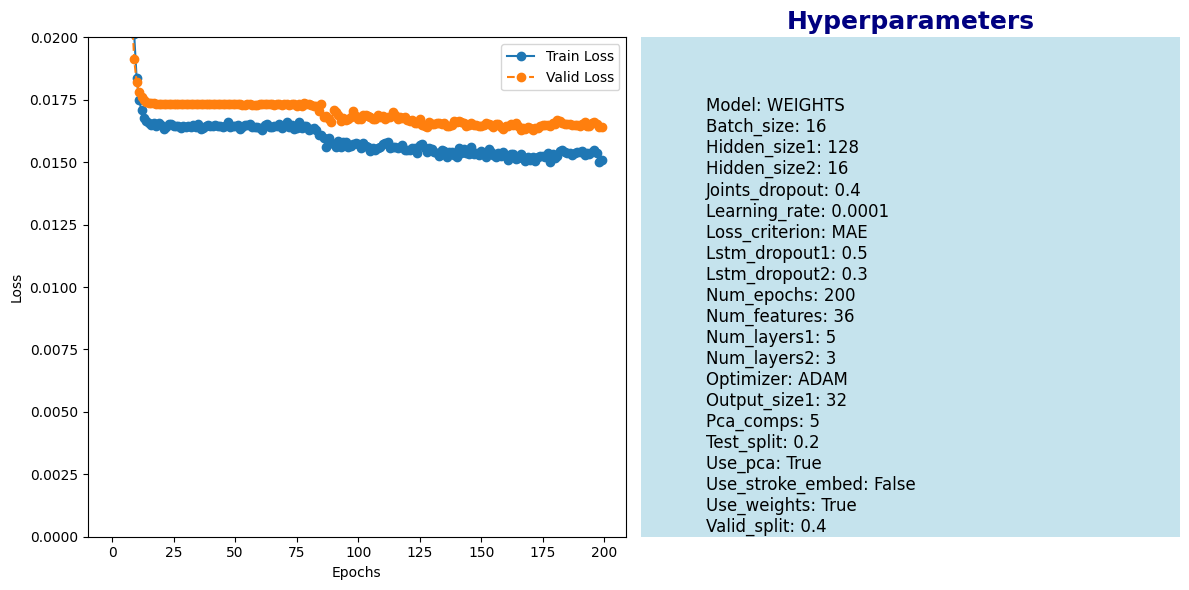

In [ ]:
# Plot the train-valid losses

# Replace with the desired experiment path
experiment_path = os.path.join(CURRENT_EXP_DIR, 'version_0')

# Load the CSV file
csv_file_path = experiment_path+'/metrics.csv'
df = pd.read_csv(csv_file_path)

# Load the hparams.yaml file
hparams_file_path = experiment_path+'/hparams.yaml'
with open(hparams_file_path, 'r') as hparams_file:
    exp_hparams = yaml.safe_load(hparams_file)

# Extract the relevant columns
train_loss = df['train_loss_epoch'].dropna().tolist()
valid_loss = df['valid_loss'].dropna().tolist()

# Create a list to keep track of epoch boundaries
epochs = range(0, exp_hparams["num_epochs"])

# Create subplots for loss, accuracy, and hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot train_loss_epoch and valid_loss together
axs[0].plot(epochs, train_loss, label='Train Loss', marker='o')
axs[0].plot(epochs, valid_loss, label='Valid Loss', marker='o', linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_ylim(0.0, 0.02)

# Extract all hyperparameters and their values
all_hyperparameters = exp_hparams.items()

# Create a vertical list of hyperparameters with formatting
hyperparameter_list = "\n".join([f"{key.capitalize()}: {value}" for key, value in all_hyperparameters])

# Create a fancy box with rounded corners and shadow for the text
bbox_params = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightblue', alpha=0.7)
text_box = FancyBboxPatch((0.1, 0.1), 0.8, 0.8, boxstyle="round, pad=0.5", edgecolor='black', facecolor='lightblue', alpha=0.7, transform=axs[1].transAxes, zorder=0)

# Add the fancy box to the plot
axs[1].add_patch(text_box)

# Add the formatted hyperparameters text to the text box
axs[1].text(0.12, 0.88, hyperparameter_list, fontsize=12, verticalalignment='top')

# Remove the axes for a cleaner look
axs[1].axis('off')

# Set a title for hyperparameters with custom font and color
axs[1].set_title('Hyperparameters', fontsize=18, fontweight='bold', color='navy')

# Customize the layout
plt.tight_layout()

# Save the plot as an image
image_path = os.path.join(experiment_path, 'loss_plot.png')
plt.savefig(image_path)

# Show the plots
plt.show()

# **TESTING PHASE**

In [ ]:
# REPLACE with the DESIRED EXPERIMENT DIRECTORY
EXPERIMENT_DIR = '/content/drive/MyDrive/Napoli_Project/experiments/tplr_2024-01-10_12-29-46'
CHECKPOINT_PATH = '/content/drive/MyDrive/Napoli_Project/experiments/tplr_2024-01-10_12-29-46/valid_loss=0.016292-epoch=171.ckpt'

In [ ]:
# Load the hparams.yaml file
hparams_file_path = experiment_path+'/hparams.yaml'
with open(hparams_file_path, 'r') as hparams_file:
    exp_hparams = yaml.safe_load(hparams_file)
    print(exp_hparams)

{'MODEL': 'WEIGHTS', 'batch_size': 16, 'hidden_size1': 128, 'hidden_size2': 16, 'joints_dropout': 0.4, 'learning_rate': 0.0001, 'loss_criterion': 'MAE', 'lstm_dropout1': 0.5, 'lstm_dropout2': 0.3, 'num_epochs': 200, 'num_features': 36, 'num_layers1': 5, 'num_layers2': 3, 'optimizer': 'ADAM', 'output_size1': 32, 'pca_comps': 5, 'test_split': 0.2, 'use_PCA': True, 'use_stroke_embed': False, 'use_weights': True, 'valid_split': 0.4}


In [ ]:
experiment_path = os.path.join(EXPERIMENT_DIR, 'version_0')
TEST_DIR = os.path.join(EXPERIMENT_DIR, 'test')

## **TEST LOSS**

In [ ]:
# Load the hparams.yaml file
hparams_file_path = experiment_path+'/hparams.yaml'
with open(hparams_file_path, 'r') as hparams_file:
    exp_hparams = yaml.safe_load(hparams_file)
    print(exp_hparams)

{'MODEL': 'WEIGHTS', 'batch_size': 16, 'hidden_size1': 128, 'hidden_size2': 16, 'joints_dropout': 0.4, 'learning_rate': 0.0001, 'loss_criterion': 'MAE', 'lstm_dropout1': 0.5, 'lstm_dropout2': 0.3, 'num_epochs': 200, 'num_features': 36, 'num_layers1': 5, 'num_layers2': 3, 'optimizer': 'ADAM', 'output_size1': 32, 'pca_comps': 5, 'test_split': 0.2, 'use_PCA': True, 'use_stroke_embed': False, 'use_weights': True, 'valid_split': 0.4}


In [ ]:
# Load the model weights from checkpoint

"""
    Before executing this cell, first execute these sections:

      IMPORTS and DIRECTORIES

      DATASET CLASS and DATALOADER

      MODELS => ONLY the specific one related to the experiment checkpoint!!!

      """

with open(TEST_DIR+"/test_data.pickle", "rb") as file:
    test_data = pickle.load(file)

with open(TEST_DIR+"/test_pca_data.pickle", "rb") as file:
    test_pca_data = pickle.load(file)

with open(TEST_DIR+"/test_weights.pickle", "rb") as file:
    test_weights = pickle.load(file)

with open(TEST_DIR+"/test_cat_and_stroke.pickle", "rb") as file:
    test_cat_and_stroke = pickle.load(file)

with open(TEST_DIR+"/test_labels.pickle", "rb") as file:
    test_labels = pickle.load(file)


test_dm = TPLRDataModule(
    train_data=None,
    valid_data=None,
    test_data=test_data,

    train_pca_data=None,
    valid_pca_data=None,
    test_pca_data=test_pca_data,

    train_weights=None,
    valid_weights=None,
    test_weights=test_weights,

    train_cat_and_stroke=None,
    valid_cat_and_stroke=None,
    test_cat_and_stroke=test_cat_and_stroke,

    train_labels=None,
    valid_labels=None,
    test_labels=test_labels,

    batch_size= exp_hparams['batch_size']
)

test_model = TPLRModel.load_from_checkpoint(CHECKPOINT_PATH, hparams_file = hparams_file_path)

tester = pl.Trainer(accelerator='auto')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Let the trainer test the Tennis Players Level Recognizer.

test_loss = tester.test(model=test_model, datamodule=test_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.01932871714234352    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# Save the test loss in a .txt file
test_loss = test_loss[0]['test_loss']

test_loss_path = os.path.join(TEST_DIR, f'test_loss={test_loss:.6f}.txt')

with open(test_loss_path, 'w') as file:
    # Write the number to the file
    file.write(str(test_loss))

print(test_loss)

0.01932871714234352


In [ ]:
dict_categories_inv = {0 : "AMATEUR", 1 : "EXPERT"}

dict_strokes_inv = {
    0: 'backhand',
    1: 'bslice', #no samples, remove it
    2: 'bvolley', #too few samples, remove it
    3: 'backhand2h', # missing 30 videos, but still keep it
    4: 'serflat',
    5: 'foreflat',
    6: 'foreopen',
    7: 'fslice',
    8: 'fvolley',
    9: 'serkick',
    10: 'serslice',
    11: 'smash'
}

In [ ]:
pred_scores = test_model.predictions
true_scores = test_model.true_labels
cat_and_stroke = test_model.cat_and_stroke

# convert categories and strokes into strings using the inverse-mappings provided above
cat_list = [dict_categories_inv[cat_and_stroke[i][0]] for i in range(len(cat_and_stroke))]
stroke_list = [dict_strokes_inv[cat_and_stroke[i][1]] for i in range(len(cat_and_stroke))]

num_test_videos = len(pred_scores)
print(f"The number of test videos is: {num_test_videos}")

test_results = []
for i in range(num_test_videos):
  category = cat_list[i]
  stroke = stroke_list[i]
  pred_score = pred_scores[i]
  true_score = true_scores[i]
  print(f"Player Category: {category}, Type of Stroke: {stroke}, Predicted Score: {pred_score}, True Score: {true_score}")
  test_results.append({"category":category, "stroke":stroke, "pred_score":pred_score, "true_score":true_score})

The number of test videos is: 324
Player Category: EXPERT, Type of Stroke: foreopen, Predicted Score: 0.9770533442497253, True Score: 0.9802215695381165
Player Category: EXPERT, Type of Stroke: foreopen, Predicted Score: 0.9770232439041138, True Score: 0.9828597903251648
Player Category: EXPERT, Type of Stroke: backhand2h, Predicted Score: 0.9770768284797668, True Score: 0.9765884876251221
Player Category: EXPERT, Type of Stroke: serslice, Predicted Score: 0.9770964980125427, True Score: 0.9765690565109253
Player Category: EXPERT, Type of Stroke: serflat, Predicted Score: 0.9701451063156128, True Score: 0.9780274629592896
Player Category: EXPERT, Type of Stroke: smash, Predicted Score: 0.9770675897598267, True Score: 0.9762312173843384
Player Category: AMATEUR, Type of Stroke: backhand, Predicted Score: 0.9770578145980835, True Score: 0.9630817770957947
Player Category: AMATEUR, Type of Stroke: foreflat, Predicted Score: 0.977077066898346, True Score: 0.9530202150344849
Player Category

In [ ]:
with open(TEST_DIR+"/test_results.pickle", "wb") as file:
    pickle.dump(test_results, file)

##**TEST PLOTS**

In [ ]:
with open(TEST_DIR+"/test_results.pickle", "rb") as file:
    test_results = pickle.load(file)

In [ ]:
TEST_PLOTS_DIR = os.path.join(TEST_DIR, 'plots')
try:
  os.makedirs(TEST_PLOTS_DIR)
except OSError as e1:
  print("Creation of the directory %s failed" % TEST_PLOTS_DIR)
  print("Error:", e1)
  print(traceback.format_exc())

###**TOTAL VIDEO SCORES ANALYSIS**

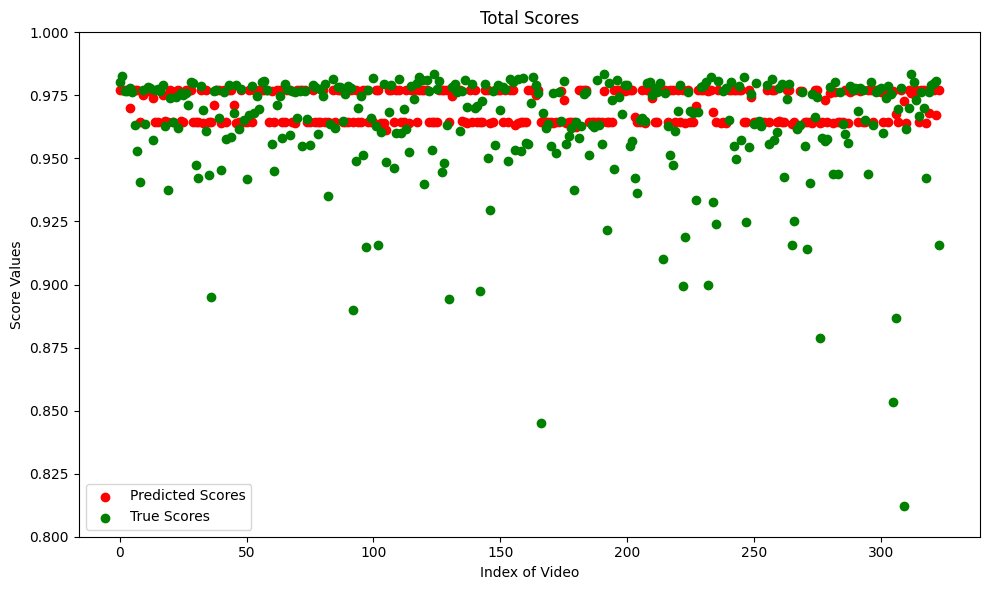

In [ ]:
# Create the plot for the comparison between predicted and true scores
plt.figure(figsize=(10, 6))

pred_scores = [result["pred_score"] for result in test_results]
true_scores = [result["true_score"] for result in test_results]

num_test_videos = len(pred_scores)

# Plot predicted scores with red dots
plt.scatter(range(num_test_videos), pred_scores, color='red', marker='o', label='Predicted Scores')

# Plot true scores with green dots
plt.scatter(range(num_test_videos), true_scores, color='green', marker='o', label='True Scores')

plt.xlabel('Index of Video')
plt.ylabel('Score Values')
plt.title('Total Scores')
plt.legend()
plt.ylim(0.80, 1)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot as an image
image_path = os.path.join(TEST_PLOTS_DIR, 'total_scores.png')
plt.savefig(image_path)

plt.show()

###**CATEGORY-BASED VIDEO SCORES ANALYSIS**

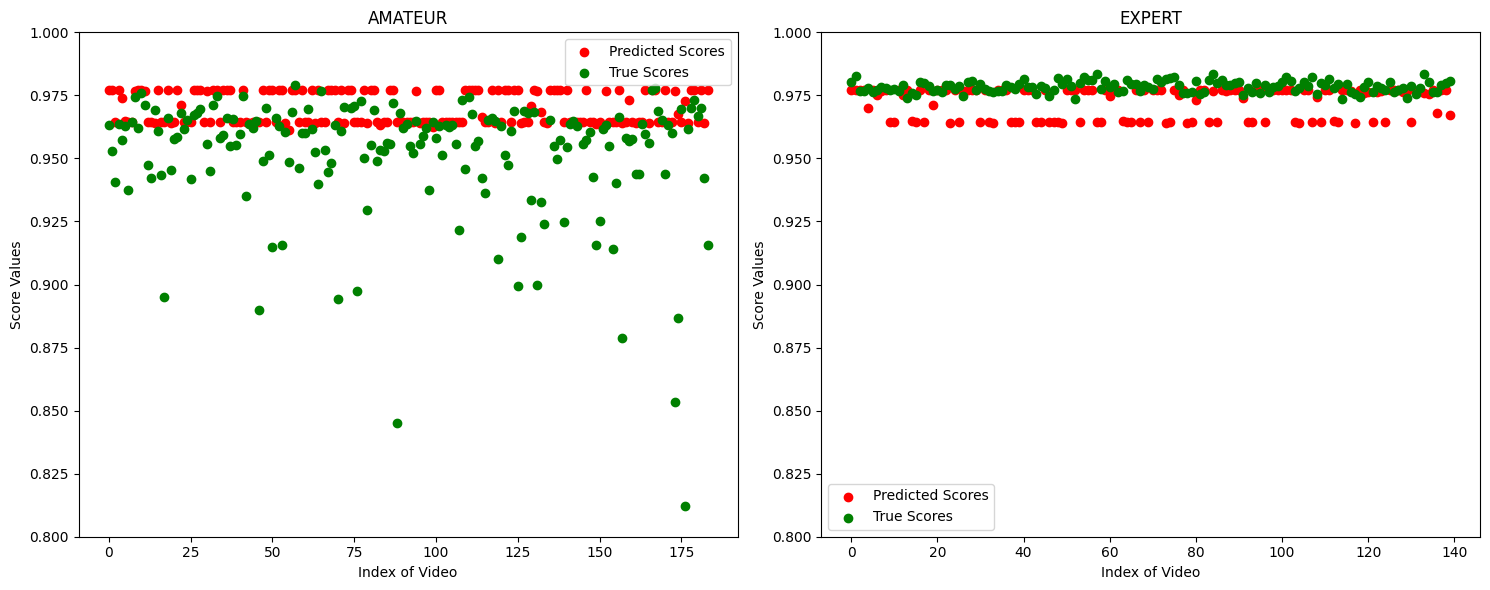

In [ ]:
# Split the data based on category
ama_pred_scores = []
ama_true_scores = []
exp_pred_scores = []
exp_true_scores = []

for result in test_results:
    if result["category"] == "AMATEUR":
        ama_pred_scores.append(result["pred_score"])
        ama_true_scores.append(result["true_score"])
    else:
        exp_pred_scores.append(result["pred_score"])
        exp_true_scores.append(result["true_score"])

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for AMA category
axs[0].scatter(range(len(ama_pred_scores)), ama_pred_scores, color='red', marker='o', label='Predicted Scores')
axs[0].scatter(range(len(ama_true_scores)), ama_true_scores, color='green', marker='o', label='True Scores')
axs[0].set_xlabel('Index of Video')
axs[0].set_ylabel('Score Values')
axs[0].set_title('AMATEUR')
axs[0].legend()
axs[0].set_ylim(0.80, 1)



# Plot for EXPERT category
axs[1].scatter(range(len(exp_pred_scores)), exp_pred_scores, color='red', marker='o', label='Predicted Scores')
axs[1].scatter(range(len(exp_true_scores)), exp_true_scores, color='green', marker='o', label='True Scores')
axs[1].set_xlabel('Index of Video')
axs[1].set_ylabel('Score Values')
axs[1].set_title('EXPERT')
axs[1].legend()
axs[1].set_ylim(0.80, 1)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot as an image
image_path = os.path.join(TEST_PLOTS_DIR, 'category_scores.png')
plt.savefig(image_path)

# Show the plot
plt.show()


###**STROKE-BASED VIDEO SCORES ANALYSIS**

In [ ]:
pred_scores = {
    'backhand': [],
    'backhand2h': [],
    'serflat': [],
    'foreflat': [],
    'foreopen': [],
    'fslice': [],
    'fvolley': [],
    'serkick': [],
    'serslice': [],
    'smash': []
}

true_scores = {
    'backhand': [],
    'backhand2h': [],
    'serflat': [],
    'foreflat': [],
    'foreopen': [],
    'fslice': [],
    'fvolley': [],
    'serkick': [],
    'serslice': [],
    'smash': []
}

for result in test_results:
  pred_scores[result["stroke"]].append(result["pred_score"])
  true_scores[result["stroke"]].append(result["true_score"])

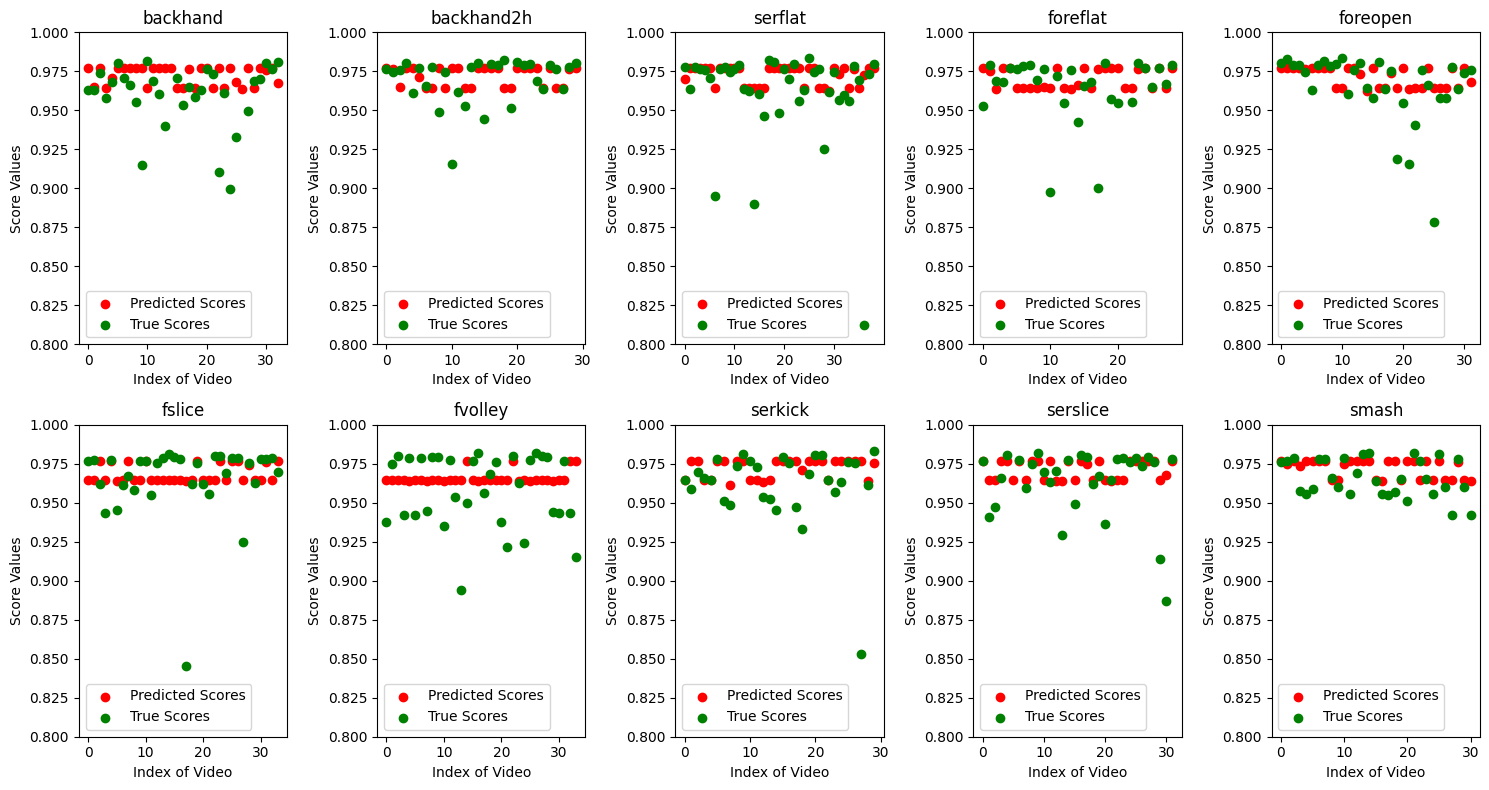

In [ ]:
# Create a 2x5 subplot
fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Plot for each stroke
for i, stroke in enumerate(pred_scores.keys()):
    # Plot predicted scores with red dots
    axs[i].scatter(range(len(pred_scores[stroke])), pred_scores[stroke], color='red', marker='o', label='Predicted Scores')

    # Plot true scores with green dots
    axs[i].scatter(range(len(true_scores[stroke])), true_scores[stroke], color='green', marker='o', label='True Scores')

    axs[i].set_xlabel('Index of Video')
    axs[i].set_ylabel('Score Values')
    axs[i].set_title(f'{stroke}')
    axs[i].legend()
    axs[i].set_ylim(0.80, 1)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot as an image
image_path = os.path.join(TEST_PLOTS_DIR, 'stroke_scores.png')
plt.savefig(image_path)

# Show the plot
plt.show()

###**CATEGORY&STROKE-BASED VIDEO SCORES ANALYSIS**

In [ ]:
def create_stroke_dicts(test_results):
  pred_scores = {
      'backhand': [],
      'backhand2h': [],
      'serflat': [],
      'foreflat': [],
      'foreopen': [],
      'fslice': [],
      'fvolley': [],
      'serkick': [],
      'serslice': [],
      'smash': []
  }

  true_scores = {
      'backhand': [],
      'backhand2h': [],
      'serflat': [],
      'foreflat': [],
      'foreopen': [],
      'fslice': [],
      'fvolley': [],
      'serkick': [],
      'serslice': [],
      'smash': []
  }

  for result in test_results:
    pred_scores[result["stroke"]].append(result["pred_score"])
    true_scores[result["stroke"]].append(result["true_score"])

  return pred_scores, true_scores

In [ ]:
def create_subplots(pred_scores, true_scores, category):

  # Create a 2x5 subplot
  fig, axs = plt.subplots(2, 5, figsize=(15, 8))

  # Flatten the axs array for easy indexing
  axs = axs.flatten()

  # Plot for each stroke
  for i, stroke in enumerate(pred_scores.keys()):
      # Plot predicted scores with red dots
      axs[i].scatter(range(len(pred_scores[stroke])), pred_scores[stroke], color='red', marker='o', label='Predicted Scores')

      # Plot true scores with green dots
      axs[i].scatter(range(len(true_scores[stroke])), true_scores[stroke], color='green', marker='o', label='True Scores')

      axs[i].set_xlabel('Index of Video')
      axs[i].set_ylabel('Score Values')
      axs[i].set_title(f'{category}_{stroke}')
      axs[i].legend()
      axs[i].set_ylim(0.80, 1)

  # Adjust layout to prevent overlapping
  plt.tight_layout()

  # Save the plot as an image
  image_path = os.path.join(TEST_PLOTS_DIR, f'{category}_stroke_scores.png')
  plt.savefig(image_path)

  # Show the plot
  plt.show()

In [ ]:
ama_test_results = []
exp_test_results = []

for result in test_results:
  if result["category"] == "AMATEUR":
    ama_test_results.append(result)
  else:
    exp_test_results.append(result)

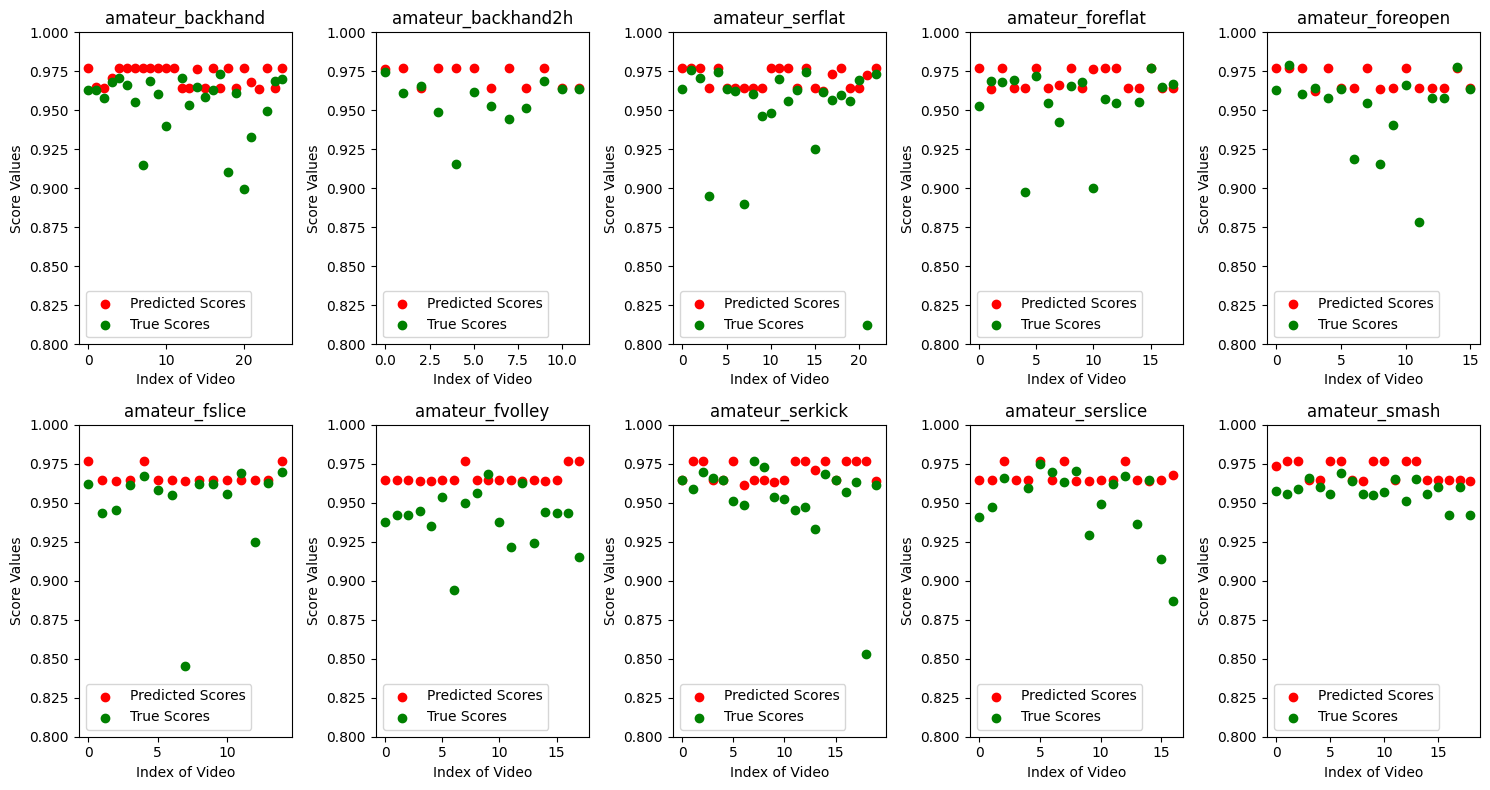

In [ ]:
ama_pred_scores, ama_true_scores = create_stroke_dicts(ama_test_results)

create_subplots(ama_pred_scores, ama_true_scores, 'amateur')

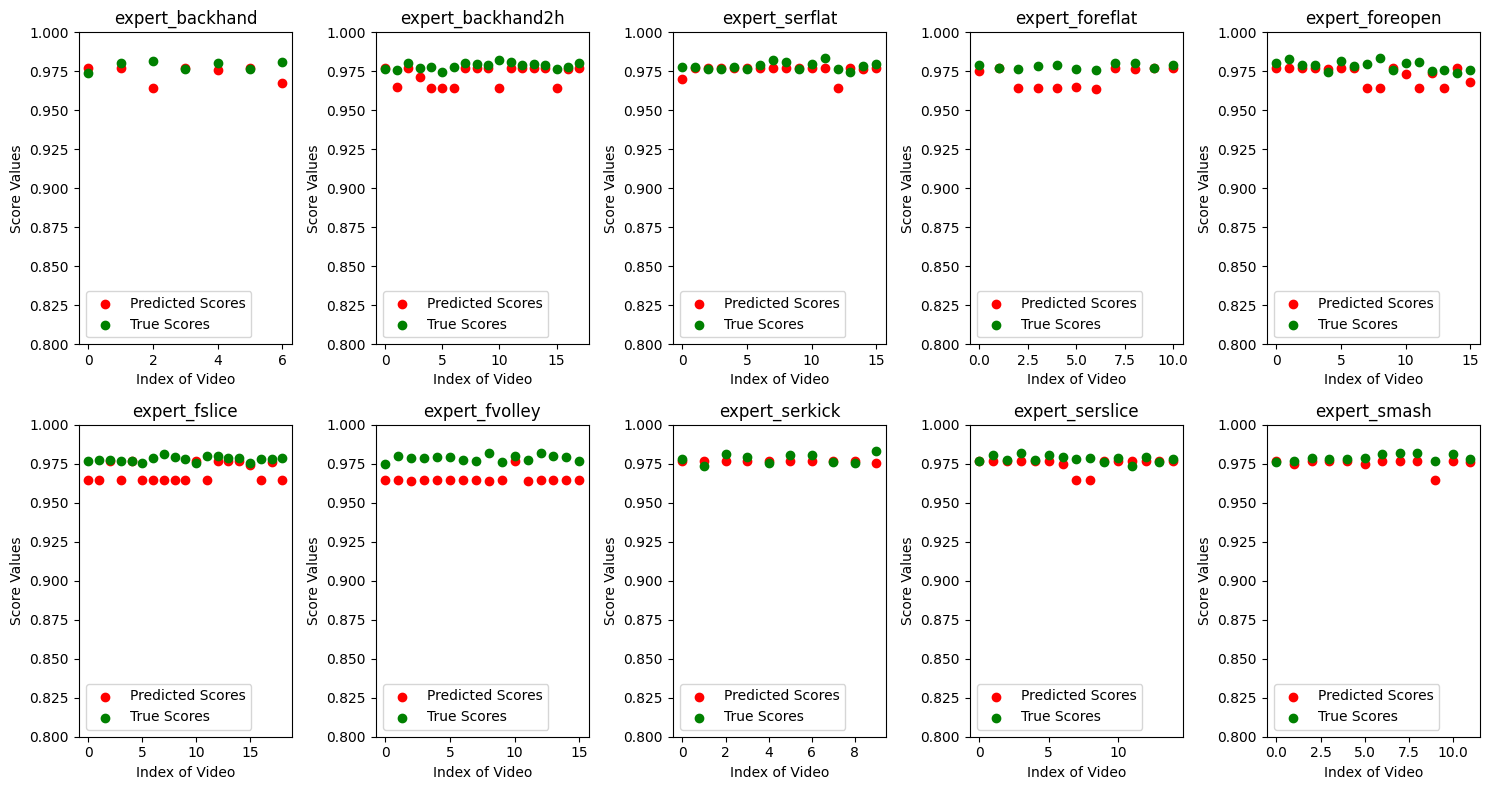

In [ ]:
exp_pred_scores, exp_true_scores = create_stroke_dicts(exp_test_results)

create_subplots(exp_pred_scores, exp_true_scores, 'expert')

# **COMPARISON**



Compare results to the ones obtained by performing *Liao et al.* [A Deep Learning Framework for Assessing Physical Rehabilitation Exercises](https://arxiv.org/abs/1901.10435) model on our data.

## **Imports**

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import os
from os.path import exists, join, basename, splitext

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt

# length of data sequences
seq_len = 152
# dimension of data sequences
n_dim = 36
batch_size = 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PROJECT_DIR = '/content/drive/MyDrive/Napoli_Project'
FILES_DIR = PROJECT_DIR + '/files'
COMPARISONS_DIR = PROJECT_DIR + '/comparisons'

In [4]:
import pickle

with open(FILES_DIR+"/scaled_data.pickle", "rb") as file:
    data = pickle.load(file)

with open(FILES_DIR+"/cat_and_stroke_list.pickle", "rb") as file:
    cat_and_stroke = pickle.load(file)

with open(FILES_DIR+"/mh_scores.pickle", "rb") as file:
    labels = pickle.load(file)

## **Preprocessing**

In [ ]:
data_dict = {}
labels_dict = {}

for i, video_info in enumerate(cat_and_stroke):
  stroke = video_info[1]
  if stroke not in data_dict:
    data_dict[stroke] = [data[i]]
    labels_dict[stroke] = [labels[i]]
  else:
    data_dict[stroke].append(data[i])
    labels_dict[stroke].append(labels[i])

for key in data_dict.keys():
  data_dict[key] = np.array(data_dict[key])


In [ ]:
# The temporal pyramid requires that the length of the data sequences is divisible by 8.
# The original length was 150 time steps, so we will repeat the first and last data vectors to obtain sequences with 152 time steps

for key in data_dict.keys():
  adj_data = np.concatenate((data_dict[key][:,:1,:], data_dict[key], data_dict[key][:,-1:,:]), axis = 1)
  data_dict[key] = adj_data
  labels_dict[key] = np.array(labels_dict[key])
  print('Training sequences dimension', data_dict[key].shape)
  print('Testing labels dimension', labels_dict[key].shape)

In [ ]:
def split(data, labels, test_size=0.3):
  #suddivision in training set and testing sets
  train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, shuffle=True)

  return train_data, test_data, train_labels, test_labels

In [ ]:
stroke_data = {}

for key in data_dict.keys():
  train_x, valid_x, train_y, valid_y = split(data_dict[key], labels_dict[key])
  stroke_data[key] = {
      "train_x" : train_x,
      "valid_x" : valid_x,
      "train_y" : train_y,
      "valid_y" : valid_y
  }

# check of dimensions
print(stroke_data[0]["train_x"].shape)
print(stroke_data[0]["train_y"].shape)

In [ ]:
# Reduce the data length by a factor of 2, 4, and 8
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
def reduce_data_length(train_x, valid_x):
  train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
  valid_x_2 = np.zeros(train_x_2.shape)
  train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
  valid_x_4 = np.zeros(train_x_4.shape)
  train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
  valid_x_8 = np.zeros(train_x_8.shape)
  train_x_2 = train_x[:,::2,:]
  valid_x_2 = valid_x[:,::2,:]
  train_x_4 = train_x[:,::4,:]
  valid_x_4 = valid_x[:,::4,:]
  train_x_8 = train_x[:,::8,:]
  valid_x_8 = valid_x[:,::8,:]

  return train_x, valid_x, train_x_2, valid_x_2, train_x_4, valid_x_4, train_x_8, valid_x_8

In [ ]:
# Code to re-order the 36 dimensional skeleton data from Kinect into trunk, right arm, left arm, right leg and left leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],2))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],6))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],6))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],6))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],6))

    X_trunk =  x[:,:,2:4]
    X_right_arm = x[:,:,4:10]
    X_left_arm = x[:,:,10:16]
    X_right_leg = x[:,:,16:22]
    X_left_leg = x[:,:,22:28]

    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented

In [ ]:
# Reorder the data dimensions to correspond to the five body parts
def reorder(train_x, valid_x, train_x_2, valid_x_2, train_x_4, valid_x_4, train_x_8, valid_x_8):
  trainx =  reorder_data(train_x)
  validx =  reorder_data(valid_x)
  trainx_2 =  reorder_data(train_x_2)
  validx_2 =  reorder_data(valid_x_2)
  trainx_4 =  reorder_data(train_x_4)
  validx_4 =  reorder_data(valid_x_4)
  trainx_8 =  reorder_data(train_x_8)
  validx_8 =  reorder_data(valid_x_8)

  return {
      "trainx":trainx,
      "validx":validx,
      "trainx_2":trainx_2,
      "validx_2":validx_2,
      "trainx_4":trainx_4,
      "validx_4":validx_4,
      "trainx_8":trainx_8,
      "validx_8":validx_8
  }

## **Model**

In [ ]:
stroke_data_dict = {}
for key in data_dict.keys():
  train_x, valid_x, train_x_2, valid_x_2, train_x_4, valid_x_4, train_x_8, valid_x_8 = reduce_data_length(stroke_data[key]["train_x"], stroke_data[key]["valid_x"])
  stroke_data_dict[key] = reorder(train_x, valid_x, train_x_2, valid_x_2, train_x_4, valid_x_4, train_x_8, valid_x_8)
  stroke_data_dict[key]["train_y"] = stroke_data[key]["train_y"]
  stroke_data_dict[key]["valid_y"] = stroke_data[key]["valid_y"]

In [ ]:
# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):
    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)
    return x

In [ ]:
# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):

    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)

    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x

In [ ]:
n_dim = 26 # dimension after reordering the data into body parts
n_dim1 = 2 # dimension of trunk
n_dim2 = 6 # dimension of each limb

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (seq_len,n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:,:,2:4])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:,:,4:10])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 10:16])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 16:22])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 22:28])(seq_input)


#### Half scale sequences
seq_input_2 = Input(shape=(int(seq_len/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:,:,2:4])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:,:,4:10])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 10:16])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 16:22])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 22:28])(seq_input_2)


#### Quarter scale sequences
seq_input_4 = Input(shape=(int(seq_len/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:,:,2:4])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:,:,4:10])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 10:16])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 16:22])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 22:28])(seq_input_4)


#### Eighth scale sequences
seq_input_8 = Input(shape=(int(seq_len/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:,:,2:4])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:,:,4:10])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 10:16])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 16:22])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 22:28])(seq_input_8)


concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, seq_len, n_dim1)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, seq_len, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, seq_len, n_dim1)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, seq_len, n_dim1)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, seq_len, n_dim1)


concat = concatenate([concat_trunk, concat_right_arm, concat_left_arm, concat_right_leg, concat_left_leg], axis=-1)

rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'sigmoid')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.0001))


## **Training**

In [ ]:
dict_categories_inv = {0 : "AMATEUR", 1 : "EXPERT"}

dict_strokes_inv = {
    0: 'backhand',
    1: 'bslice', #no samples, remove it
    2: 'bvolley', #too few samples, remove it
    3: 'backhand2h', # missing 30 videos, but still keep it
    4: 'serflat',
    5: 'foreflat',
    6: 'foreopen',
    7: 'fslice',
    8: 'fvolley',
    9: 'serkick',
    10: 'serslice',
    11: 'smash'
}

2024-01-11_13-57-15
2/2 [==============================] - 0s 32ms/step


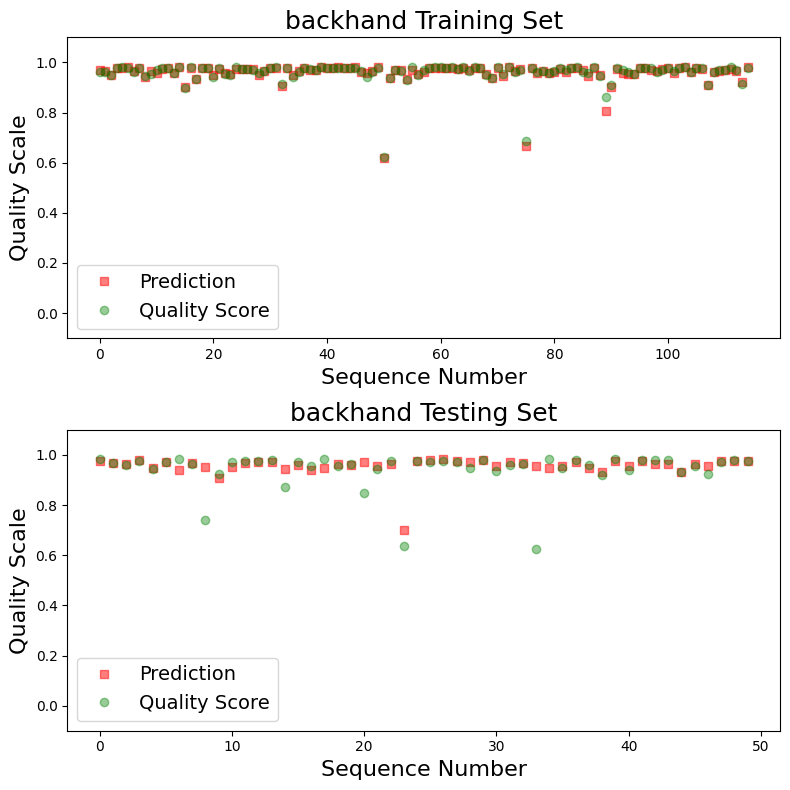

backhand Mean absolute deviation: 0.025650264481479782
backhand RMS deviation: 0.06136658298201075
2/2 [==============================] - 0s 23ms/step


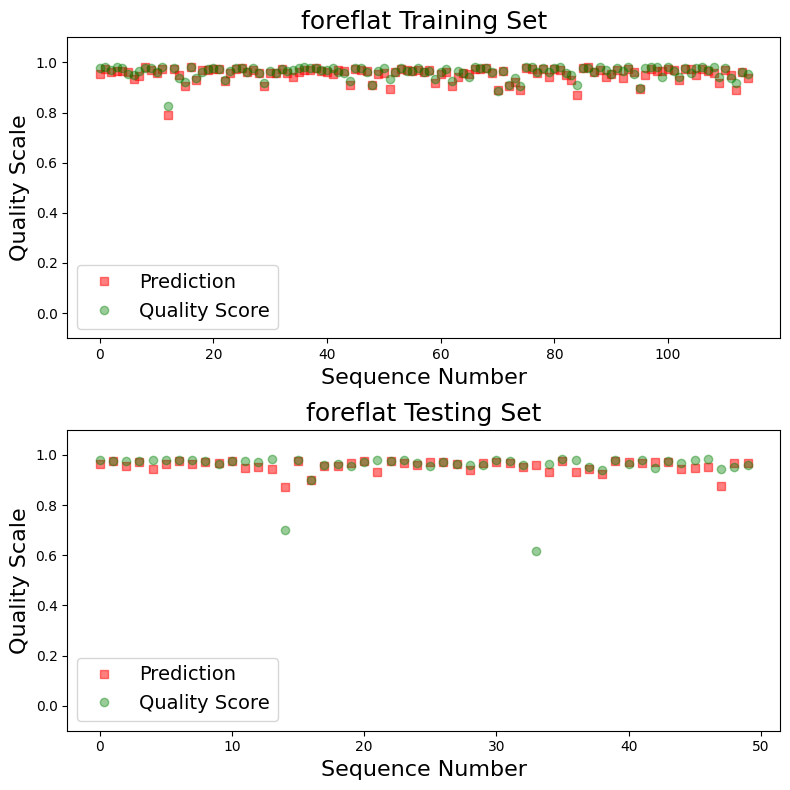

foreflat Mean absolute deviation: 0.025097489256687124
foreflat RMS deviation: 0.05808728131964336
2/2 [==============================] - 0s 23ms/step


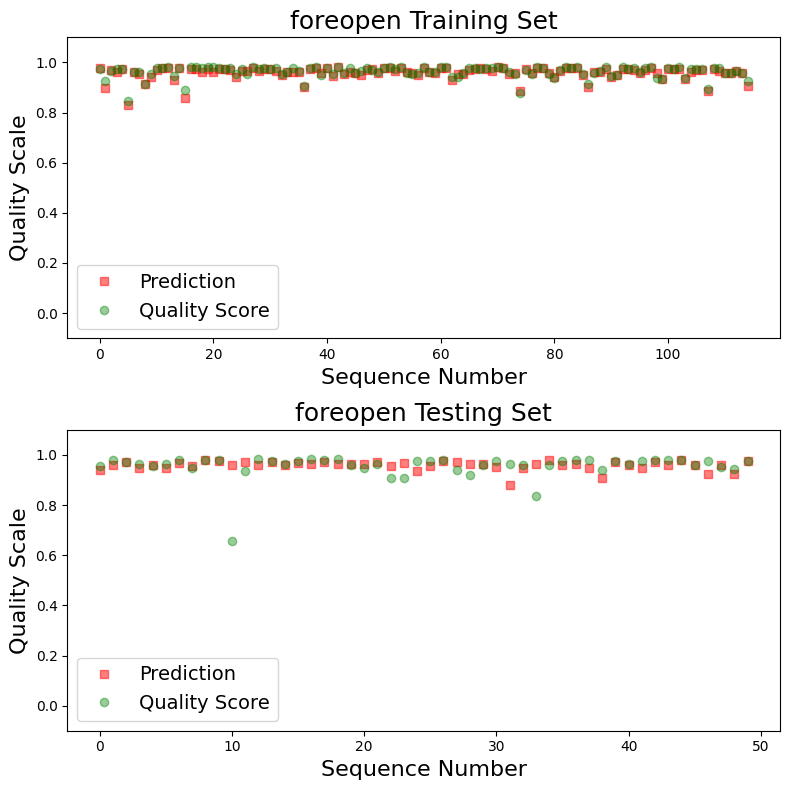

foreopen Mean absolute deviation: 0.02617654905718653
foreopen RMS deviation: 0.052766116069613594
2/2 [==============================] - 0s 25ms/step


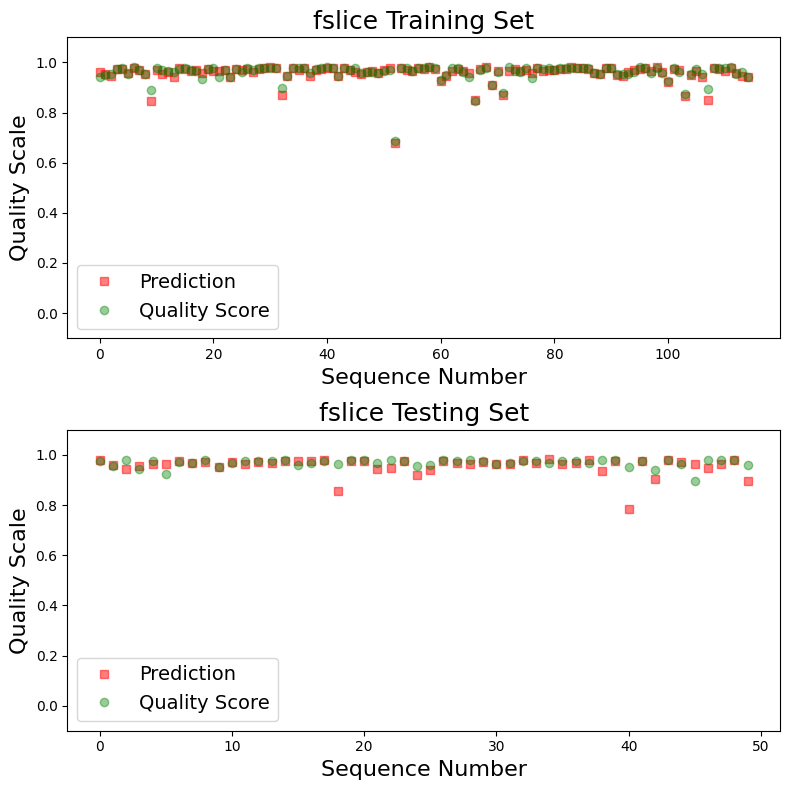

fslice Mean absolute deviation: 0.018820009897209933
fslice RMS deviation: 0.03489424850874797
2/2 [==============================] - 0s 25ms/step


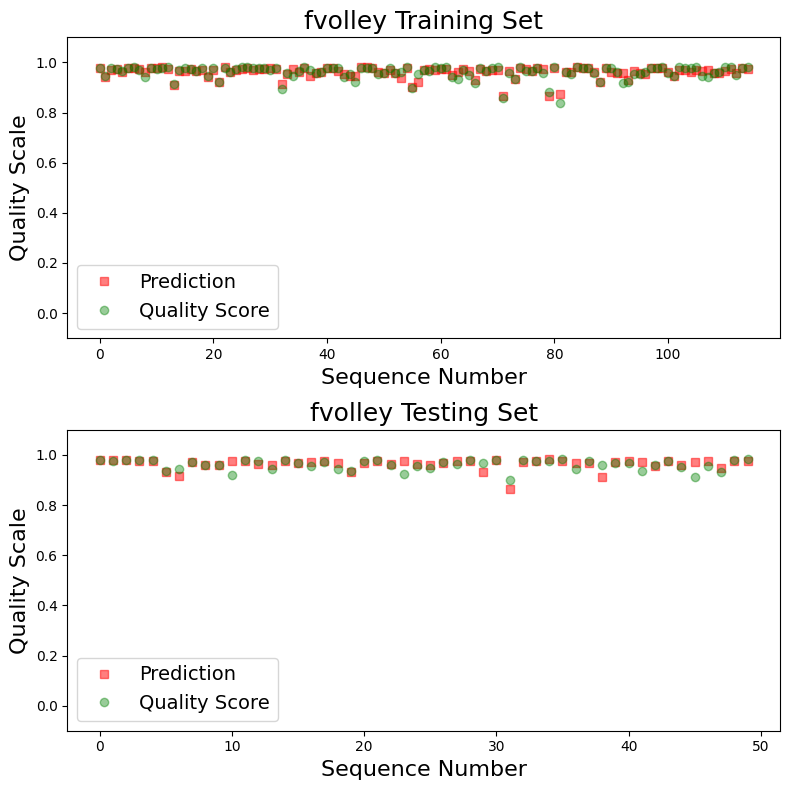

fvolley Mean absolute deviation: 0.012510595733717903
fvolley RMS deviation: 0.01963783575924044
2/2 [==============================] - 0s 36ms/step


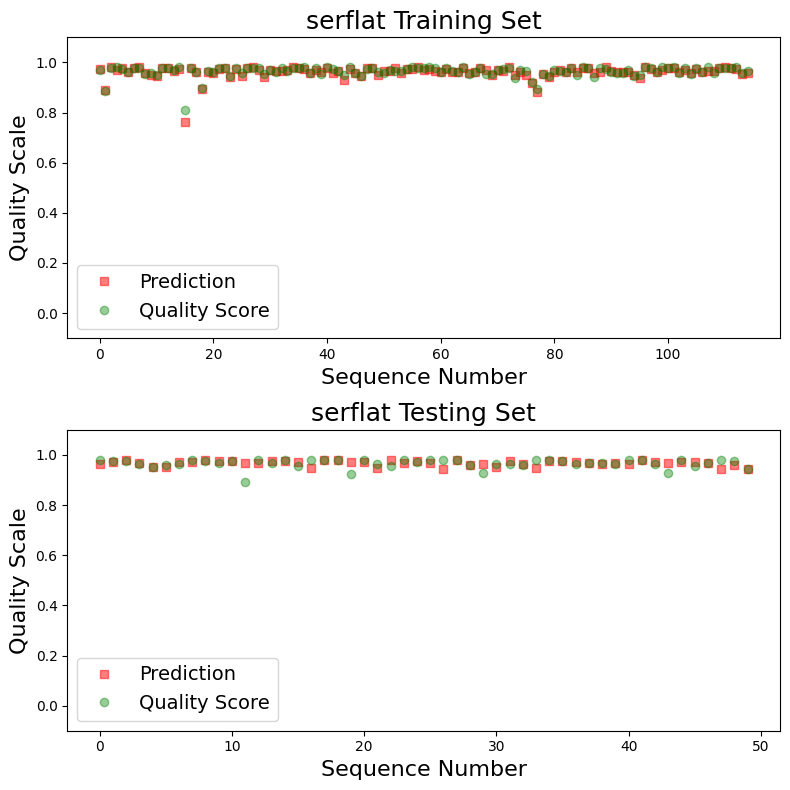

serflat Mean absolute deviation: 0.01253591500215659
serflat RMS deviation: 0.019696619853982304
2/2 [==============================] - 0s 32ms/step


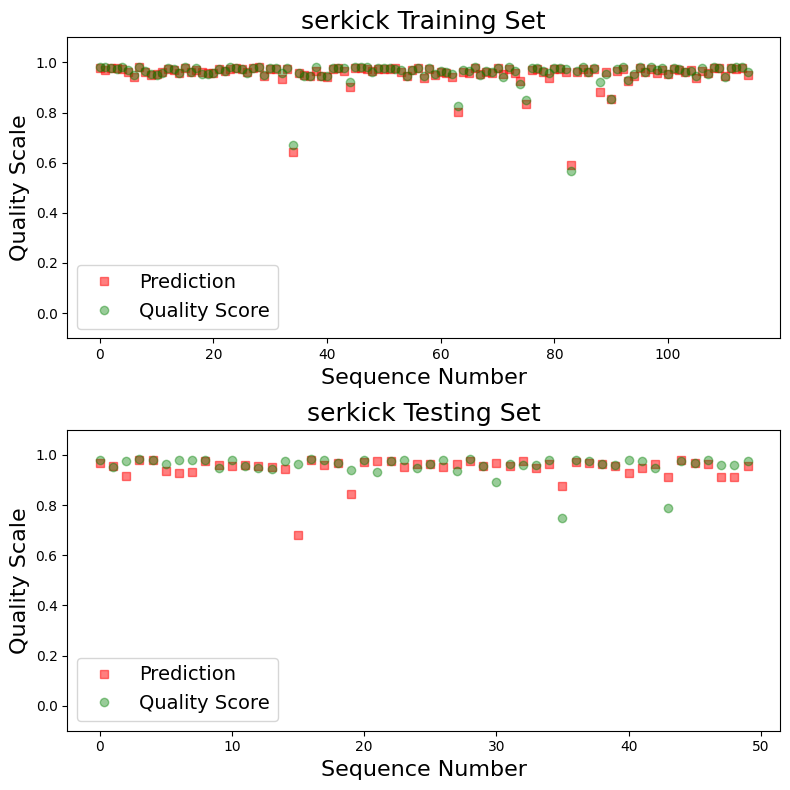

serkick Mean absolute deviation: 0.029823485112970477
serkick RMS deviation: 0.05523841173009359
2/2 [==============================] - 0s 28ms/step


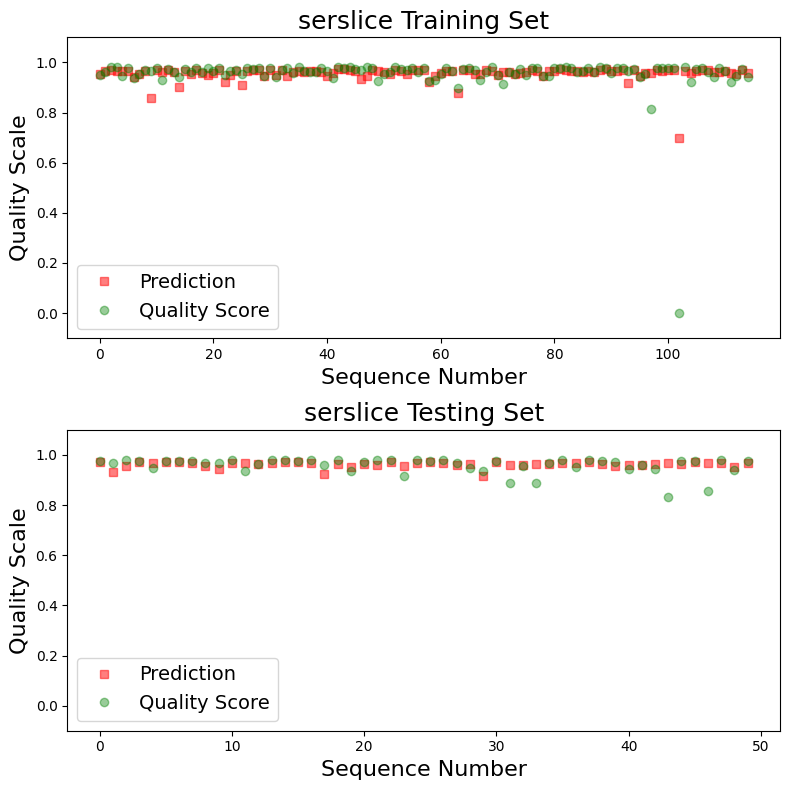

serslice Mean absolute deviation: 0.019862181919211443
serslice RMS deviation: 0.032702311010279636
2/2 [==============================] - 0s 25ms/step


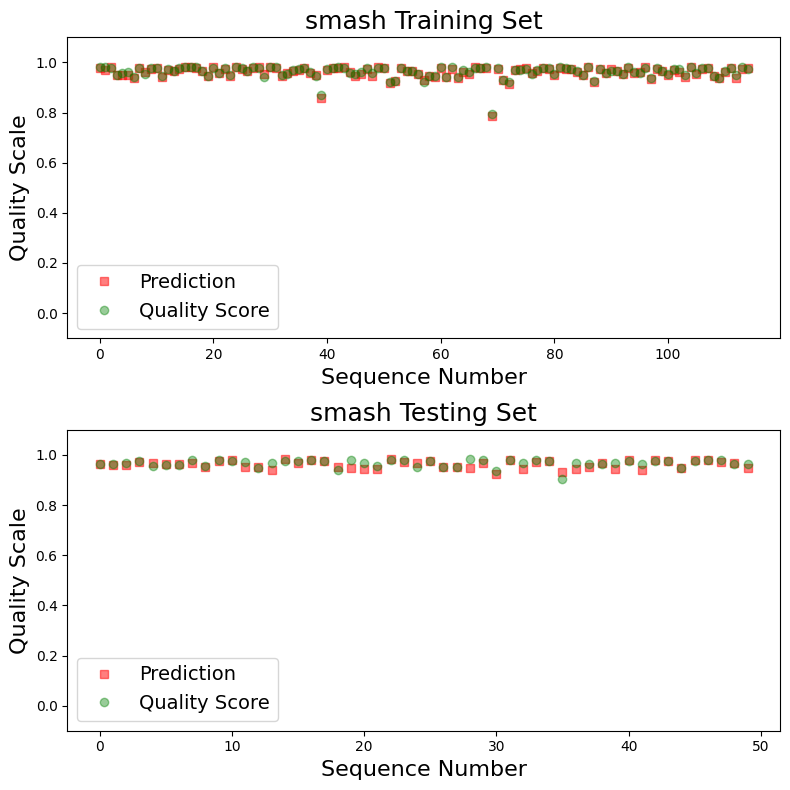

smash Mean absolute deviation: 0.009708926800683105
smash RMS deviation: 0.0135228456468304
2/2 [==============================] - 0s 24ms/step


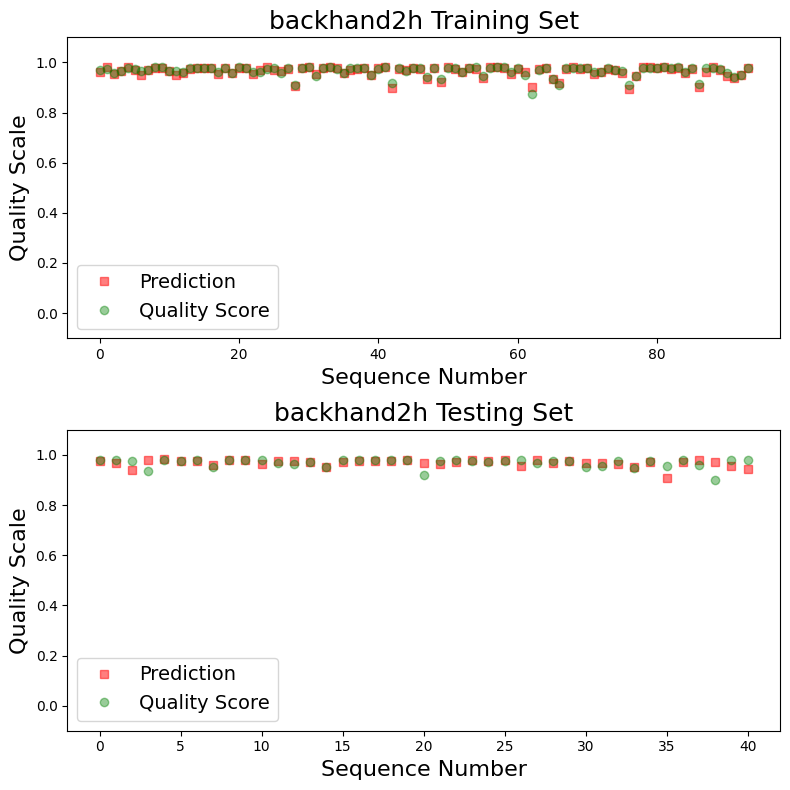

backhand2h Mean absolute deviation: 0.013036703125739318
backhand2h RMS deviation: 0.020560587911495093


In [ ]:
num_epochs = 500
batch_size = 10

current_date_time = datetime.now()
current_datetime_rome = current_date_time + timedelta(hours=1)
desired_format = "%Y-%m-%d_%H-%M-%S"
date_time_string = current_datetime_rome.strftime(desired_format)
print(date_time_string)

save_name = date_time_string

CURRENT_COMP_DIR = os.path.join(COMPARISONS_DIR, save_name)

try:
  os.makedirs(CURRENT_COMP_DIR)
except OSError as e1:
  print("Creation of the directory %s failed" % CURRENT_COMP_DIR)
  print("Error:", e1)
  print(traceback.format_exc())

early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

for key in stroke_data_dict:
  stroke = dict_strokes_inv[key]
  STROKE_DIR = os.path.join(CURRENT_COMP_DIR, stroke)
  try:
    os.makedirs(STROKE_DIR)
  except OSError as e1:
    print("Creation of the directory %s failed" % STROKE_DIR)
    print("Error:", e1)
    print(traceback.format_exc())

  history = model.fit([stroke_data_dict[key]["trainx"], stroke_data_dict[key]["trainx_2"], stroke_data_dict[key]["trainx_4"], stroke_data_dict[key]["trainx_8"]], stroke_data_dict[key]["train_y"], batch_size=batch_size, epochs=num_epochs, verbose=0,
                  validation_data=([stroke_data_dict[key]["validx"], stroke_data_dict[key]["validx_2"], stroke_data_dict[key]["validx_4"], stroke_data_dict[key]["validx_8"]], stroke_data_dict[key]["valid_y"]), callbacks = [early_stopping])

  with open(STROKE_DIR+"/history.pickle", "wb") as file:
      pickle.dump(history, file)

  # Plot the prediction of the model for the training and validation sets
  pred_train = model.predict([stroke_data_dict[key]["trainx"], stroke_data_dict[key]["trainx_2"], stroke_data_dict[key]["trainx_4"], stroke_data_dict[key]["trainx_8"]])

  pred_test = model.predict([stroke_data_dict[key]["validx"], stroke_data_dict[key]["validx_2"], stroke_data_dict[key]["validx_4"], stroke_data_dict[key]["validx_8"]])

  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
  plt.plot(stroke_data_dict[key]["train_y"],'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
  plt.ylim([-0.1,1.1])
  plt.title(f'{stroke} Training Set',fontsize=18)
  plt.xlabel('Sequence Number',fontsize=16)
  plt.ylabel('Quality Scale',fontsize=16)
  plt.legend(loc=3, prop={'size':14}) # loc:position
  plt.subplot(2,1,2)
  plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
  plt.plot(stroke_data_dict[key]["valid_y"],'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
  plt.title(f'{stroke} Testing Set',fontsize=18)
  plt.ylim([-0.1,1.1])
  plt.xlabel('Sequence Number',fontsize=16)
  plt.ylabel('Quality Scale',fontsize=16)
  plt.legend(loc=3, prop={'size':14}) # loc:position
  plt.tight_layout()
  plt.savefig(STROKE_DIR+f'/SpatioTemporalNN_Kinect_{stroke}_Scores_quality_scale.png', dpi=300)
  plt.show()

  # Calculate the cumulative deviation and rms deviation for the validation set
  test_dev = abs(np.squeeze(pred_test)-stroke_data_dict[key]["valid_y"])
  # Cumulative deviation
  mean_abs_dev = np.mean(test_dev)
  # RMS deviation
  rms_dev = sqrt(mean_squared_error(pred_test, stroke_data_dict[key]["valid_y"]))

  mean_abs_dev_path = os.path.join(STROKE_DIR, f'{stroke}_mean_abs_dev={mean_abs_dev:.6f}.txt')

  with open(mean_abs_dev_path, 'w') as file:
      # Write the number to the file
      file.write(str(mean_abs_dev))

  rms_dev_path = os.path.join(STROKE_DIR, f'{stroke}_rms_dev={rms_dev:.6f}.txt')

  with open(rms_dev_path, 'w') as file:
      # Write the number to the file
      file.write(str(rms_dev))

  print(f'{stroke} Mean absolute deviation:', mean_abs_dev)
  print(f'{stroke} RMS deviation:', rms_dev)


## **Loss Plots**

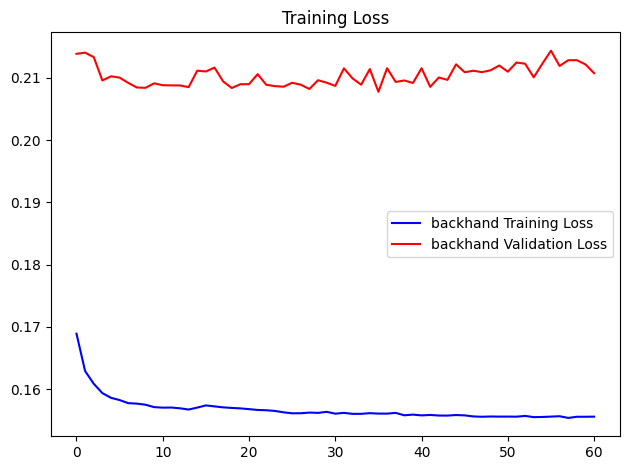

backhand Training loss 0.15535345673561096
backhand Validation loss 0.20775462687015533


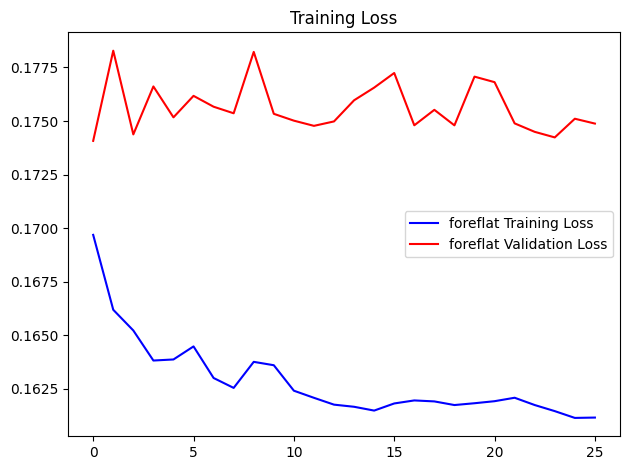

foreflat Training loss 0.1611374169588089
foreflat Validation loss 0.17407268285751343


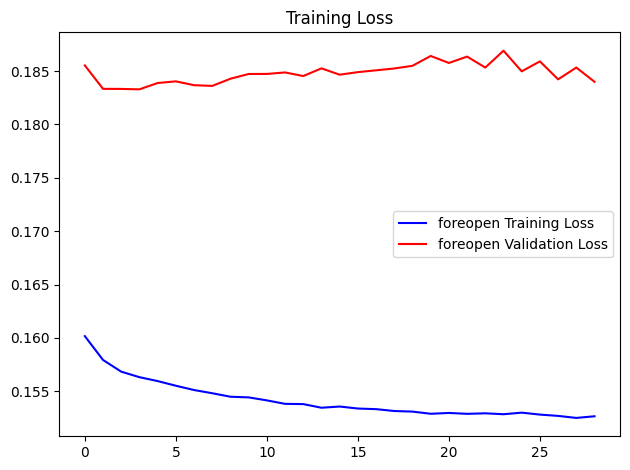

foreopen Training loss 0.15250690281391144
foreopen Validation loss 0.18329328298568726


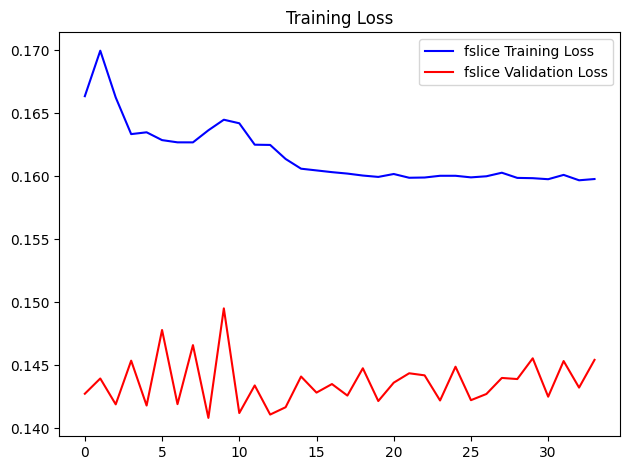

fslice Training loss 0.15967485308647156
fslice Validation loss 0.1408105343580246


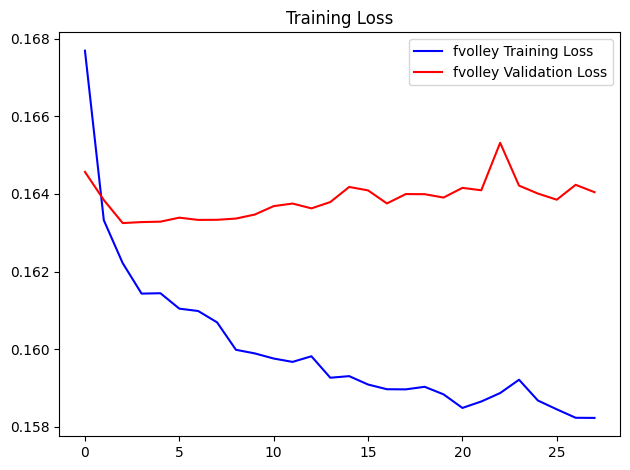

fvolley Training loss 0.15822544693946838
fvolley Validation loss 0.16324880719184875


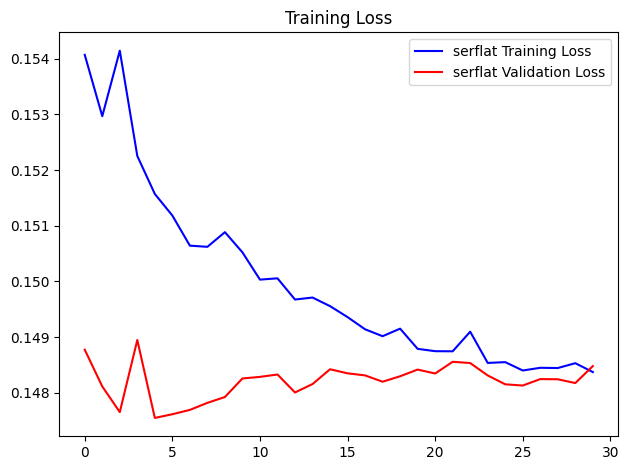

serflat Training loss 0.14837278425693512
serflat Validation loss 0.14754930138587952


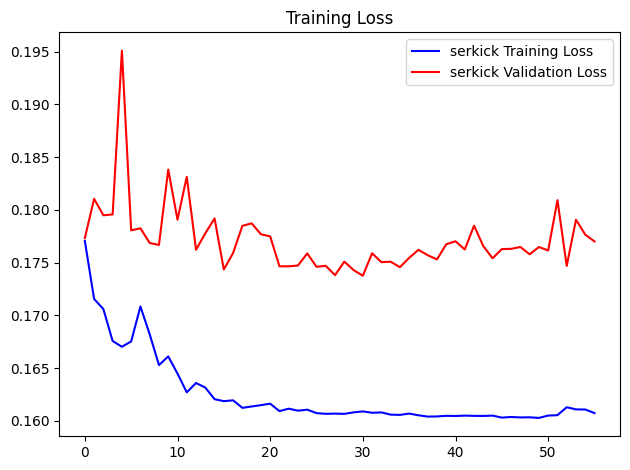

serkick Training loss 0.16026762127876282
serkick Validation loss 0.17374959588050842


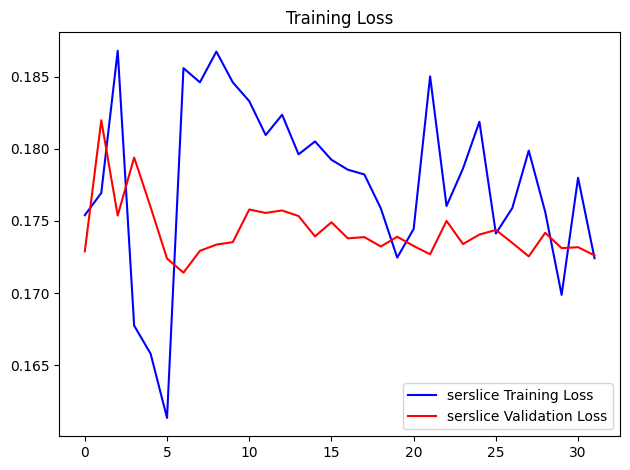

serslice Training loss 0.16134366393089294
serslice Validation loss 0.17141684889793396


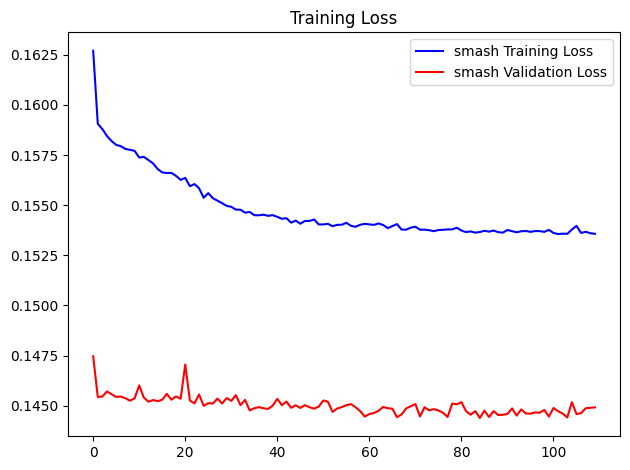

smash Training loss 0.1535598188638687
smash Validation loss 0.14438901841640472


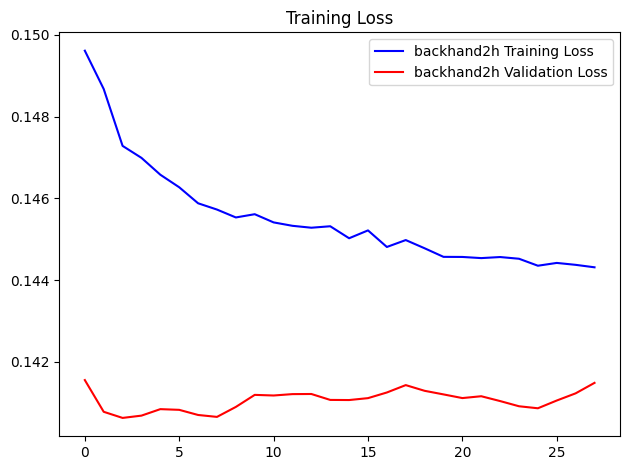

backhand2h Training loss 0.14431431889533997
backhand2h Validation loss 0.1406327486038208


In [ ]:
COMP_DIR = '/content/drive/MyDrive/Napoli_Project/comparisons/2024-01-11_13-57-15'
stroke_list = os.listdir(COMP_DIR)

for stroke in stroke_list:

  STROKE_DIR = os.path.join(COMP_DIR, stroke)
  with open(STROKE_DIR+"/history.pickle", "rb") as file:
    history = pickle.load(file)

  # Plot the results
  plt.figure(1)
  plt.plot(history.history['loss'], 'b', label = f'{stroke} Training Loss')
  plt.title('Training Loss')
  plt.plot(history.history['val_loss'], 'r', label = f'{stroke} Validation Loss')
  plt.legend()
  plt.tight_layout()
  plt.savefig(STROKE_DIR+f'/SpatioTemporalNN_Kinect_Scores_{stroke}_loss.png', dpi=300)
  plt.show()

  # Print the minimum loss
  print(f"{stroke} Training loss", np.min(history.history['loss']))
  print(f"{stroke} Validation loss", np.min(history.history['val_loss']))

  train_loss = np.min(history.history['loss'])

  train_loss_path = os.path.join(STROKE_DIR, f'{stroke}_train_loss={train_loss:.6f}.txt')

  with open(train_loss_path, 'w') as file:
      # Write the number to the file
      file.write(str(train_loss))

  test_loss = np.min(history.history['val_loss'])

  test_loss_path = os.path.join(STROKE_DIR, f'{stroke}_test_loss={test_loss:.6f}.txt')

  with open(test_loss_path, 'w') as file:
      # Write the number to the file
      file.write(str(test_loss))

## **Results**

In [7]:
COMP_DIR = '/content/drive/MyDrive/Napoli_Project/comparisons/2024-01-11_13-21-42'
stroke_list = os.listdir(COMP_DIR)

# initialize cumulative variable for the Mean Absolute Error (MAE) values
MAE_sum = 0

for stroke in stroke_list:
  # take the value of MAE for the current stroke
  STROKE_DIR = os.path.join(COMP_DIR, stroke)
  files_list = os.listdir(STROKE_DIR)
  for file_name in files_list:
    if 'mean_abs_dev' in file_name:
      mae_path = os.path.join(STROKE_DIR, file_name)
      with open(mae_path, 'r') as file:
        mae = float(file.read())
        print(f"The MAE for {stroke} is {mae}.")
        # sum it to the cumulative variable
        MAE_sum += mae

# compute the mean over all the 10 strokes
total_MAE = MAE_sum/10
print(f"The MAE over all the 10 strokes is {total_MAE}.")
total_MAE_path = os.path.join(COMP_DIR, f'total_MAE={total_MAE:.6f}.txt')
with open(total_MAE_path, 'w') as file:
    # Write the number to the file
    file.write(str(total_MAE))

The MAE for backhand is 0.031578639502606934.
The MAE for foreflat is 0.02351864265328816.
The MAE for foreopen is 0.024032980102441703.
The MAE for fslice is 0.013829929671615015.
The MAE for fvolley is 0.014389981884258208.
The MAE for serflat is 0.011355133102141394.
The MAE for serkick is 0.022578945589140812.
The MAE for serslice is 0.01830000318402434.
The MAE for smash is 0.012981130621338474.
The MAE for backhand2h is 0.011006012950910695.
The MAE over all the 10 strokes is 0.018357139926176574.
